**<span style="font-size:3em;">Credit scoring</span>**


In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this 'Credit Scoring' is by default hidden.
To toggle on/off the code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import calendar

from code_source.dataset import *
from code_source.exploration.plots import *
from code_source.exploration.dates import DateContainer
from code_source.exploration.age import AgeContainer
from code_source.exploration.customertype import CustomerTypeContainer
from code_source.exploration.correlation import CorrelationContainer
from code_source.features.evaluation import calculate_revenue_curve
from code_source.features.woe import WOE;

import scorecardpy as sc
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from xgboost import XGBClassifier
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter('ignore')

Binning on 348806 rows and 9 columns in 00:00:17


# Problem statement 

**Objective**  
Predict customers, who will default on a loan.  
Maximize revenue given business variables and developed predictive model.

# Dataset description

In [3]:
df_original = Dataset.df
df = Dataset.clean_df

**df_original** - original dataset  (relative path - /creditScoring/data/loans.csv)
Dataset contains a sample of **one month loans**.  
Every row in the table is one loan, issued for one month. 

Row count: **{{len(df_original.index)}}**  
Column count: **{{len(df_original.columns)}}**  
**'Default'** is a dependent column that I have to to predict  

|Column | Data Type |NaN value count|Description | Comment|
|:-----|:---------|--------|---|---|  
| Customer_WID | {{str(df_original.Customer_WID.dtypes)}} |{{df_original.Customer_WID.isna().sum()}} |Unique customer identifier |  |
| DisbursementDate | {{str(df_original.DisbursementDate.dtypes)}} |{{df_original.DisbursementDate.isna().sum()}}| Date, when loan was disbursed  ||
| Age | {{str(df_original.Age.dtypes)}} | {{df_original.Age.isna().sum()}}| Customer age  ||
| CustomerType | {{str(df_original.CustomerType.dtypes)}} | {{df_original.Age.isna().sum()}}|Internal customer type classification||  
| SOR | {{str(df_original.SOR.dtypes)}} | {{df_original.SOR.isna().sum()}}|A metric of customer relationship with the bank ||   
| MonthsSinceOpen | {{str(df_original.MonthsSinceOpen.dtypes)}} | {{df_original.MonthsSinceOpen.isna().sum()}}|Number of months since first account for the customer  ||
| MonthsSinceActive | {{str(df_original.MonthsSinceActive.dtypes)}} | {{df_original.MonthsSinceActive.isna().sum()}}|Number of months since last activity || 
| FinancialMeasure1 | {{str(df_original.FinancialMeasure1.dtypes)}} |{{df_original.FinancialMeasure1.isna().sum()}}| Some measure of financial activity of a customer  ||
| FinancialMeasure2 | {{str(df_original.FinancialMeasure2.dtypes)}} | {{df_original.FinancialMeasure2.isna().sum()}}|Some measure of financial activity of a customer  ||
| FinancialMeasure3 | {{str(df_original.FinancialMeasure3.dtypes)}} |{{df_original.FinancialMeasure3.isna().sum()}}| Some measure of financial activity of a customer ||
| FinancialMeasure4 | {{str(df_original.FinancialMeasure4.dtypes)}} | {{df_original.FinancialMeasure4.isna().sum()}}|Some measure of financial activity of a customer  ||
| CRBScore | {{str(df_original.CRBScore.dtypes)}} | {{df_original.CRBScore.isna().sum()}}|Credit rating bureau score  
| Amount | {{str(df_original.Amount.dtypes)}} |{{df_original.Amount.isna().sum()}}| Loan amount || 
| **Default** | {{str(df_original.Default.dtypes)}} |{{df_original.Default.isna().sum()}}| 1 - Defaulted on this loan, 0 - paid||

# Data exploration 

## General loan trends

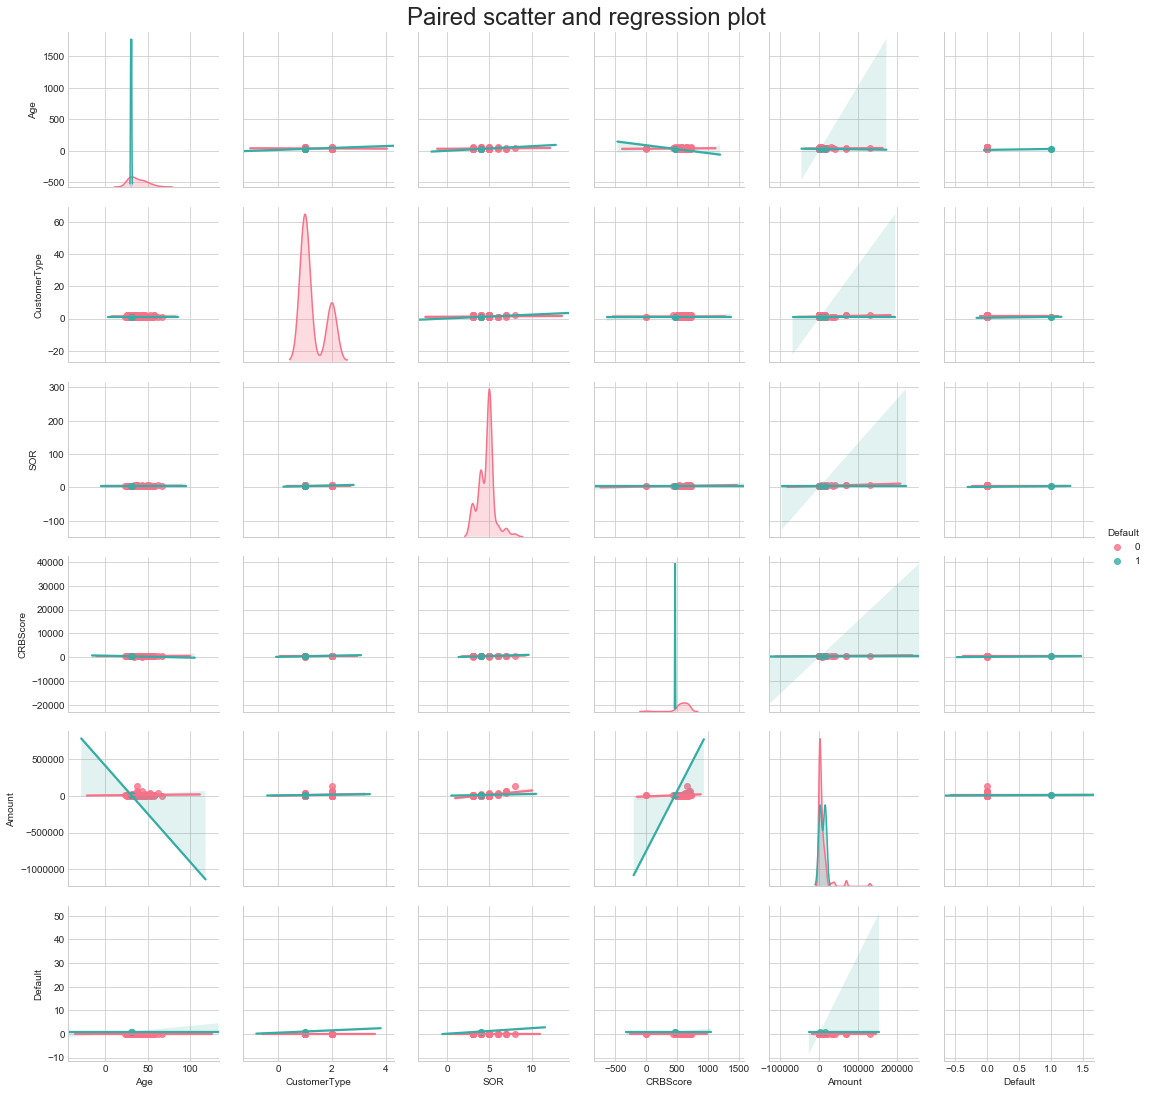

In [4]:
tmp = df[['Age', 'CustomerType', 'SOR','CRBScore', 'Amount','Default']].iloc[:100]
pairplot(tmp)

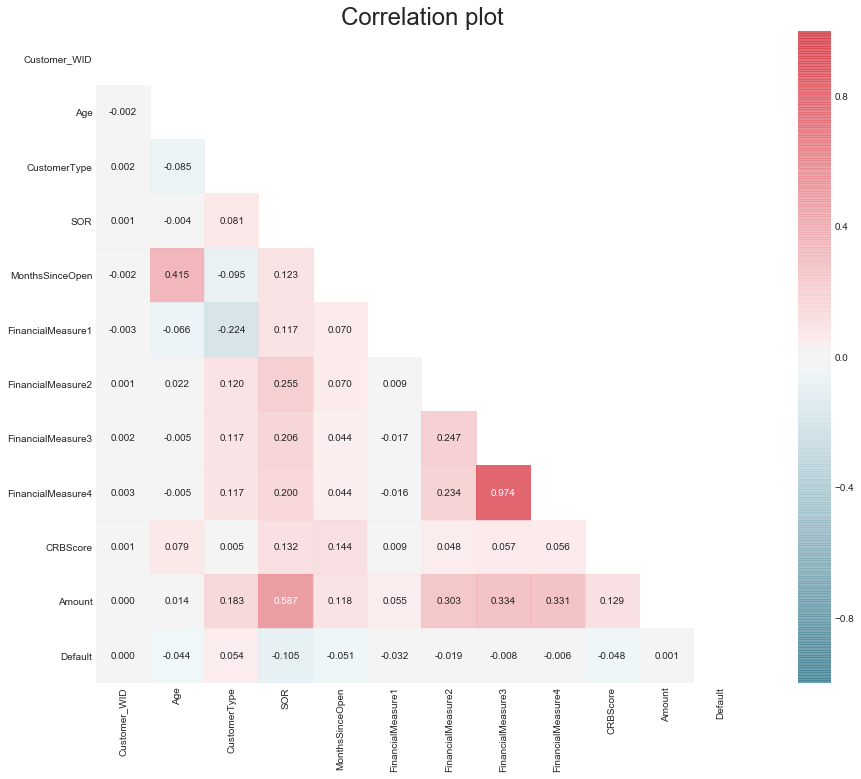

In [5]:
tmp = df_original.drop(columns='MonthsSinceActive').corr()
heatmap(tmp)

**Paired scatter and regression plot** and **Correlation plot** above shows the following facts:  
* All covariates have a small negative correlation with Default, the most important correlation is with CRBScore (**{{CorrelationContainer.corr_CRBScore_Default}}**)
* MonthsSinceOpen correlates with age (**{{CorrelationContainer.corr_MonthsSinceOpen_Age}}**), telling that there is a substantial part of long term customers with the bank  
* SOR correlates with Amount (**{{CorrelationContainer.corr_SOR_Amount}}**), telling that perhaps SOR is used to set limits for a loan amount  
* Financial Measures correlate with Amount, telling that Financial Measures could be customer income or average balances  
* There is a very strong (**{{CorrelationContainer.corr_FM1_FM2}}**) correlation between FinancialMeasure3 and FinancialMeasure4, which could make it more difficult to interpret regression coefficients. Perhaps I might need to use only one of them in my models.  

In [6]:
df_original.MonthsSinceActive.value_counts(dropna = False)

0.0    499988
NaN        11
2.0         1
Name: MonthsSinceActive, dtype: int64

In the original dataset **'MonthsSinceActive'** column has 11 'NaN' values and 1 value equals to '2', all others values are equal to '0'. It is a good indicator, it means that all customers are active. These column has been removed from **'df'** dataset because all values are the same and it will not help in prediction.

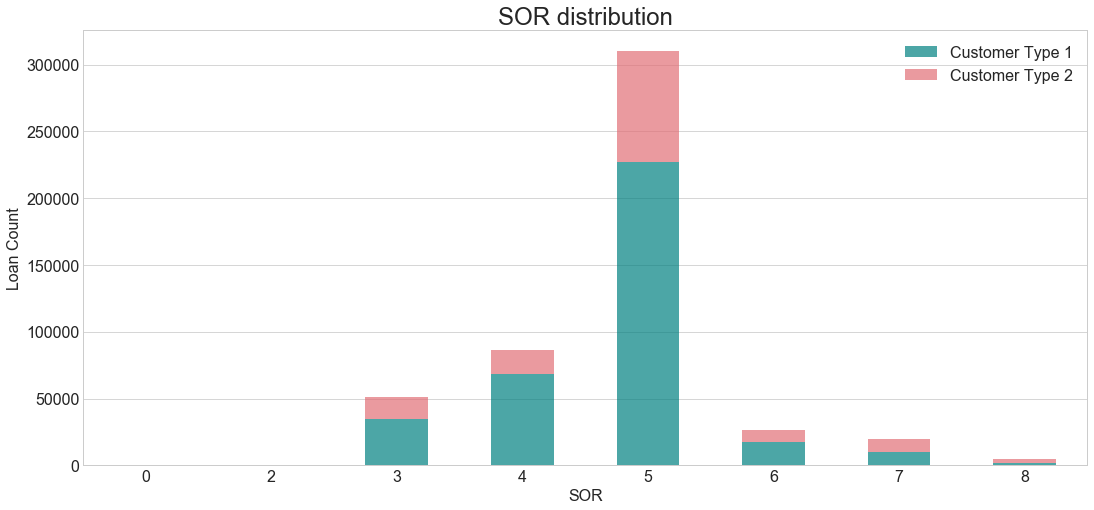

In [7]:
tmp = df.groupby(['SOR','CustomerType'])['Customer_WID'].count().reset_index(name = 'LoanCount')
tmp = tmp.pivot(index ='SOR',columns = 'CustomerType', values='LoanCount')
tmp.columns = ['Customer Type 1', 'Customer Type 2']
tmp['SOR'] = tmp.index
tmp.SOR = tmp.SOR.astype(np.int)
tmp = tmp.fillna(0)

stacked_barplot(tmp, 
                'SOR', 
                ['Customer Type 1', 'Customer Type 2'], 
                'SOR distribution', 
                'SOR', 
                'Loan Count')

The majority of customers are in **'SOR'** 5.  
Distribution of customer type 1 and customer type 2 are stable.

In original dataset column **'DisbursementDate'** has type 'object', but contains date values so I made a type conversion to datetime in **'df'** dateset.  
Loan Disbursement Dates in dataset starts at **{{DateContainer.min_month}} {{DateContainer.year}}** ends at **{{DateContainer.max_month}} {{DateContainer.year}}**, a period is equal to **{{DateContainer.month_day_count.months}}** months and **{{DateContainer.month_day_count.days}}** days

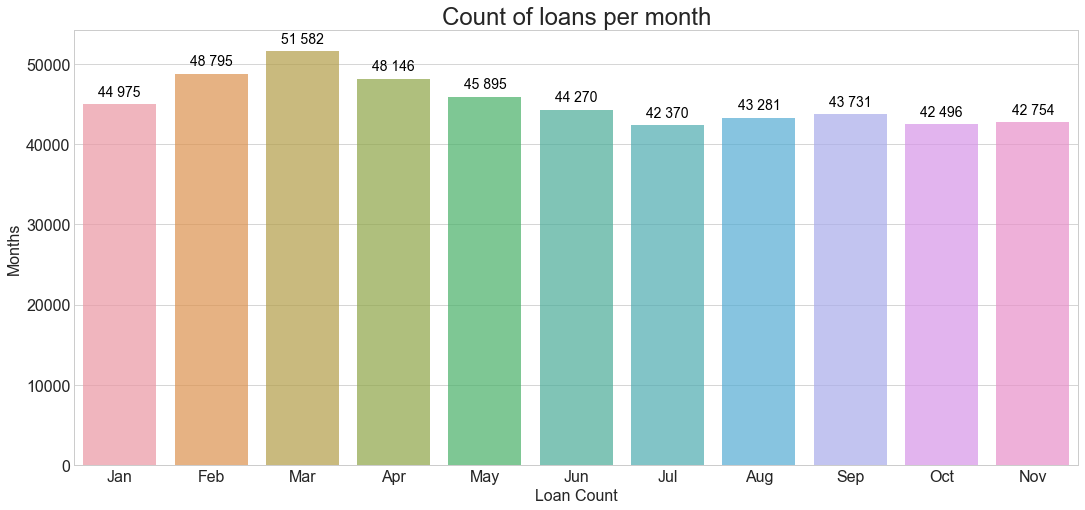

In [8]:
tmp = df.groupby(df['DisbursementDate'].dt.month)['Customer_WID']. \
        count().reset_index(name = 'LoanCount').sort_values('DisbursementDate')
loan_count_per_month_mean = tmp.LoanCount.mean()
loan_count_per_month_max = tmp.LoanCount.max()
for i in range(len(tmp.DisbursementDate)):
    tmp.DisbursementDate[i] = calendar.month_abbr[i+1]
    
barplot(tmp, 
        'DisbursementDate',
        'LoanCount', 
        'Count of loans per month', 
        'Loan Count', 
        'Months')

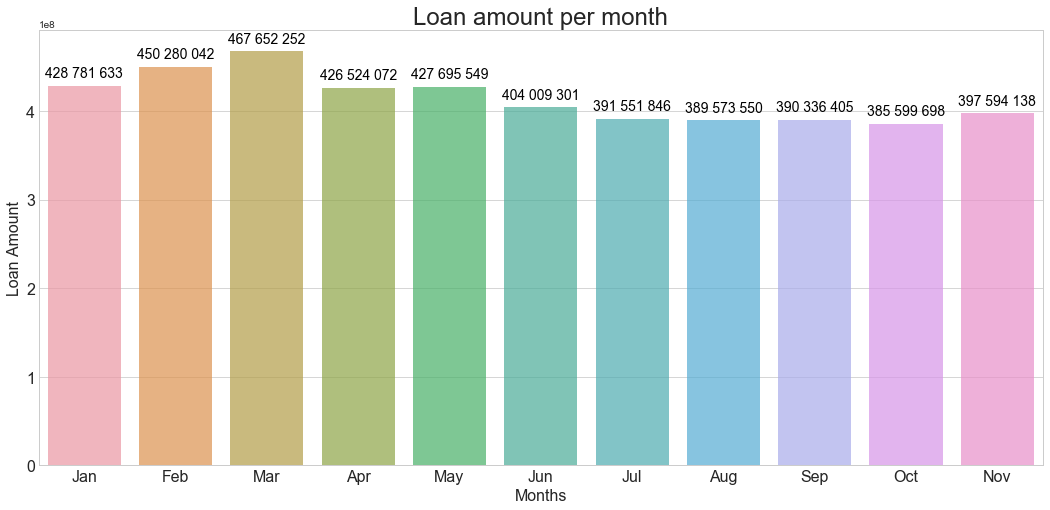

In [9]:
tmp = df.groupby(df['DisbursementDate'].dt.month)['Amount']. \
        sum().reset_index(name = 'LoanAmount').sort_values('DisbursementDate')
loan_amount_per_month_mean = tmp.LoanAmount.mean()
loan_amount_per_month_max = tmp.LoanAmount.max()
for i in range(len(tmp.DisbursementDate)):
    tmp.DisbursementDate[i] = calendar.month_abbr[i+1] 
    
barplot(tmp, 
        'DisbursementDate',
        'LoanAmount', 
        'Loan amount per month', 
        'Months', 
        'Loan Amount')

Mainly loan disbursement trend is stable with **{{format_number(round(loan_count_per_month_mean))}}** loans for a total value of **{{format_number(round(loan_amount_per_month_mean))}}** on average per month.   
But there appears to be a spike in March when **{{format_number(round(loan_count_per_month_max))}}** loans were issued for a total value of **{{format_number(round(loan_amount_per_month_max))}}**.

**Loan count and amount per day**  
Min loan count in one day: **{{format_number(round(df.groupby(df.DisbursementDate).Customer_WID.count().min()))}}**  
Max loan count in one day: **{{format_number(round(df.groupby(df_original.DisbursementDate).Customer_WID.count().max()))}}**  
Avarege loan count in one day: **{{format_number(round(df.groupby(df.DisbursementDate).Customer_WID.count().mean()))}}**  

Min loan amount in one day: **{{format_number(int(df.groupby(df_original.DisbursementDate).Amount.sum().min()))}}**  
Max loan amount in one day: **{{format_number(int(df.groupby(df_original.DisbursementDate).Amount.sum().max()))}}**  
Avarege loan amount in one day: **{{format_number(round(df.groupby(df.DisbursementDate).Amount.sum().mean()))}}**  

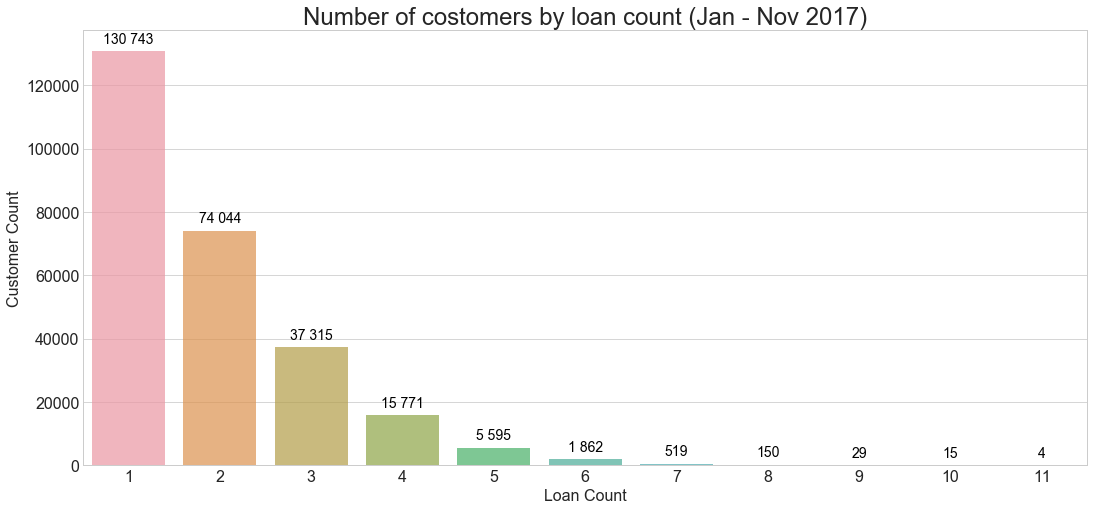

In [10]:
tmp = df.groupby('Customer_WID')['Customer_WID'].count().reset_index(name = 'LoanCount').\
groupby('LoanCount').count().reset_index().rename(columns = {'Customer_WID': 'CustomerCount'})
pct_repeat_customers = (tmp[tmp.LoanCount>1].CustomerCount.sum()/tmp.CustomerCount.sum())*100
title ='Number of costomers by loan count (%s - %s %s)' %(DateContainer.min_month_abbr,
        DateContainer.max_month_abbr, DateContainer.year)

barplot(tmp, 
        'LoanCount',
        'CustomerCount', 
        title, 
        'Loan Count', 
        'Customer Count')

The chart above shows that **{{round(pct_repeat_customers,2)}}%** of customers have taken more than 1 loan in less than one year period.

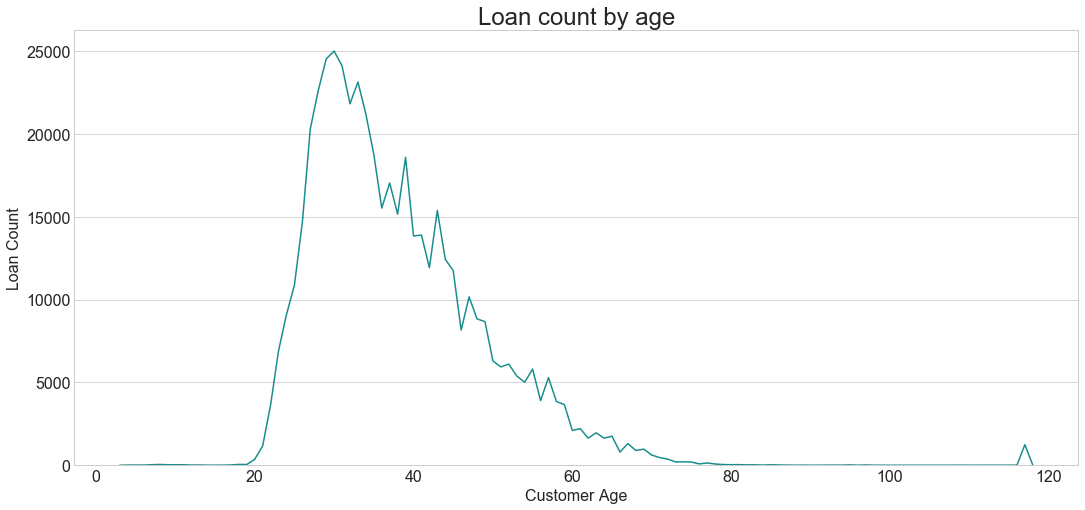

In [11]:
tmp = df_original.groupby('Age')['Customer_WID'].count()
lineplot(tmp,
         'Loan count by age',
         'Customer Age',
         'Loan Count')

The youngest customer is **{{int(df_original.Age.min())}}** years old  
The eldest customer is **{{int(df_original.Age.max())}}** years old  

The avarege customer age is **{{round(df_original.Age.mean())}}**.  
Age median is **{{round(df_original.Age.median())}}**.  
Age mode is **{{int(df_original.Age.mode())}}**, it means that the most customers take loans at 30 years.  
Age standard deviation is **{{round(df_original.Age.std(),3)}}**

**{{AgeContainer.age_less18_pct}}**% customers are younger than 18 years,  in my analysis, I will suppose that loan can only be given to a person who is at least 18 years old.  
 
**{{AgeContainer.age_more80_pct}}%** customers are between 80 years and 117 years, also {{AgeContainer.age_118_count}} customers are 118 years old. I am not sure that this data is valid and the row count is small so I will not take this data, when I do age binning.   

**{{AgeContainer.age_117_pct}}%** of customers are 117 years old. If a person born in 1900 and a loan was taken in 2017, customer can be 117 years old, but probably that is the earliest year that can be chosen and it has been put as default.  

I have removed rows where customer age is less than 18 and more than 80 in **'df'** dataset, because those rows are not trustable. Age standard deviation will be changed from **{{round(df_original.Age.std(),3)}}** to **{{round(AgeContainer.age_18_80.Age.std(),3)}}**

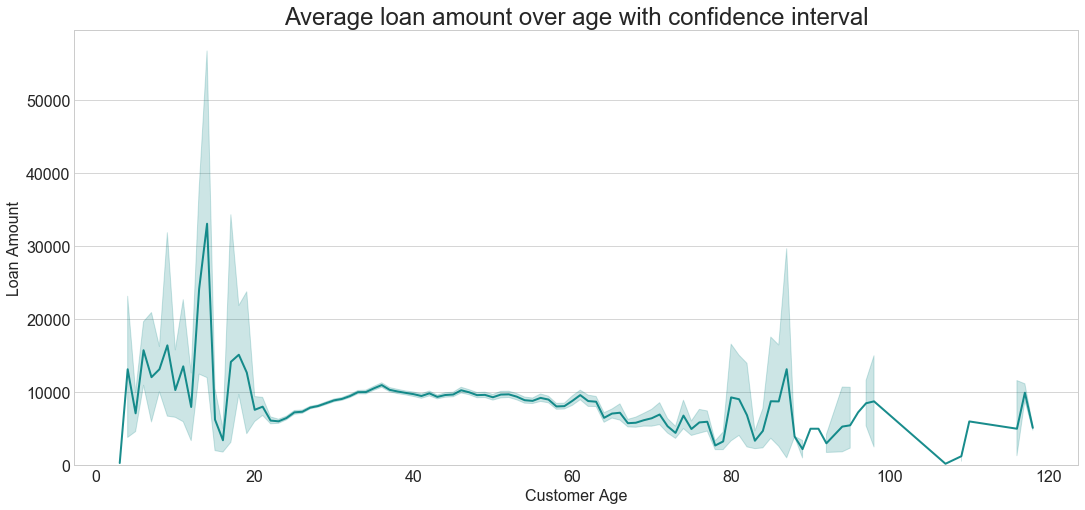

In [12]:
lineplot(df_original,
         'Average loan amount over age with confidence interval',
         'Customer Age',
         'Loan Amount',
         'Age',
         'Amount')

The line plot with error bands showing a confidence interval. For customer between 20 and 80 years errors a much smaller, than for customer who younger than 20 or elder than 80.

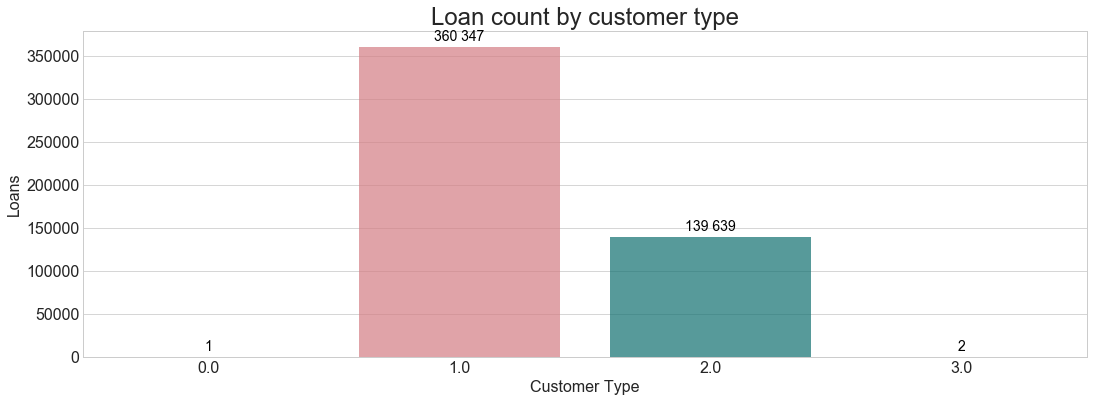

In [13]:
tmp = df_original.groupby('CustomerType').count().reset_index()
pct_loans_customer_1 = (tmp[tmp.CustomerType==1.0].Customer_WID.sum()/tmp.Customer_WID.sum())*100
pct_loans_customer_2 = (tmp[tmp.CustomerType==2.0].Customer_WID.sum()/tmp.Customer_WID.sum())*100
barplot(tmp, 
        'CustomerType', 
        'Customer_WID', 
        'Loan count by customer type',
        'Customer Type', 
        'Loans', 
        figsize=(18,6), 
        color=True)

Internal customer type classification contains two types: '1', '2', but dataset also have 2 customers with type '3' and one customer with type '0'.  
I have deleted those 3 rows from **'df'** dataset.  
The plot above shows that **{{round(pct_loans_customer_1,2)}}%** of the loans are issued to customer type **'1'**  and **{{round(pct_loans_customer_2,2)}}%** to customer type **'2'**.  
This leads me to believe that customer type **'1'** is a retail customer, while customer type **'2'** could be business or SME (small and medium enterprises) customer.

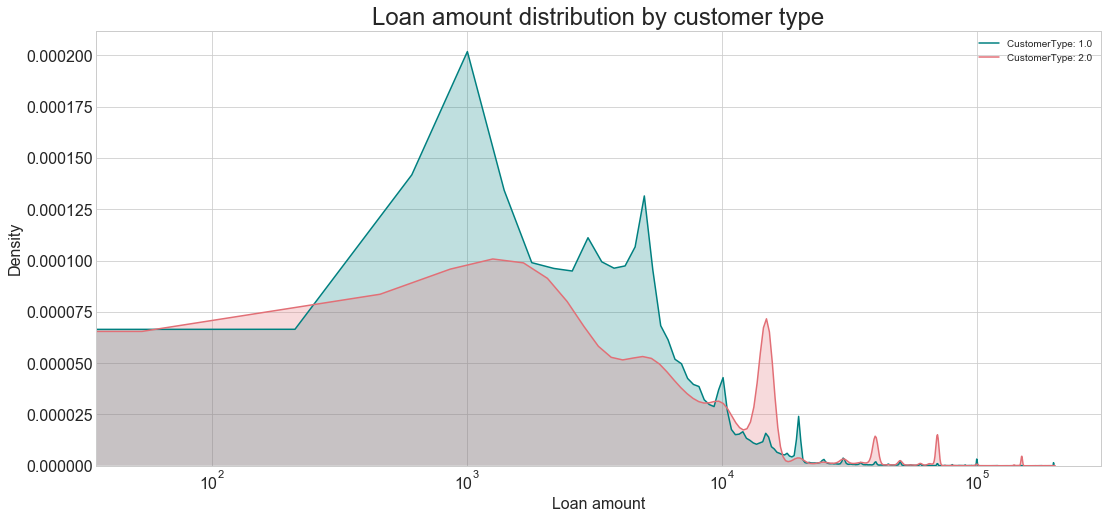

In [14]:
densityplot(df_original[df_original.CustomerType.isin([1, 2])], 
            'Amount', 
            'CustomerType', 
            'Loan amount distribution by customer type', 
            'Loan amount', 
            'Density')

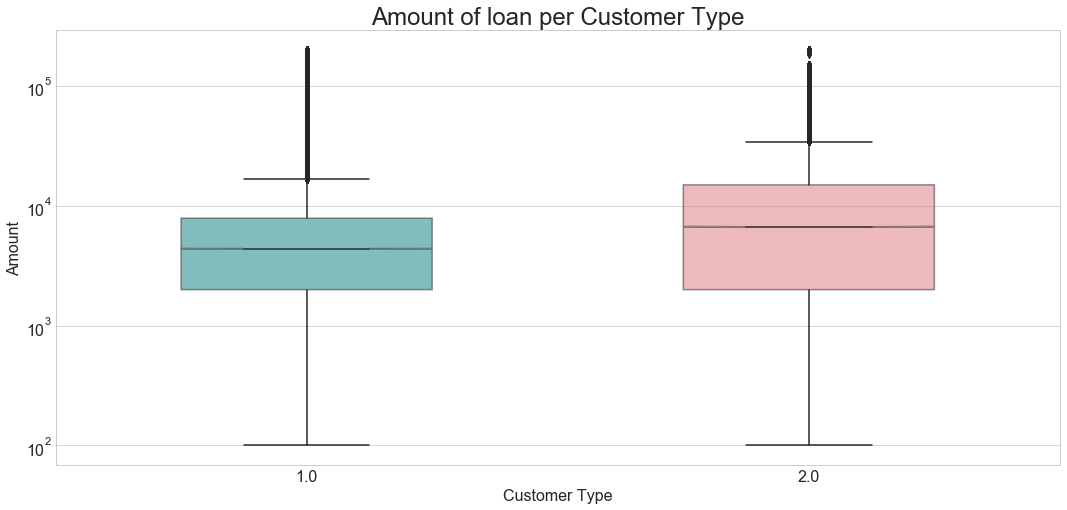

In [15]:
boxplot(df, 
        'CustomerType', 
        'Amount', 
        'Amount of loan per Customer Type', 
        'Customer Type', 
        'Amount', 
        yscale ='log')

Median amount for customer **'1'** is **{{format_number(CustomerTypeContainer.amount_median_customer_1)}}** that is lower than median for customer **'2'** with median **{{format_number(CustomerTypeContainer.amount_median_customer_2)}}**.  
Customer type **'2'** distrubution is wider than customer type **'1'** distribution.  
The minimum amount is **{{format_number(CustomerTypeContainer.amount_min_customer_2)}}**, the maximum amount is **{{format_number(int(CustomerTypeContainer.amount_max_customer_1))}}** for customer **'1'** and **'2'**

## Default predictors

Lets start predictor exploration with **Credit Rating Bureau score** 

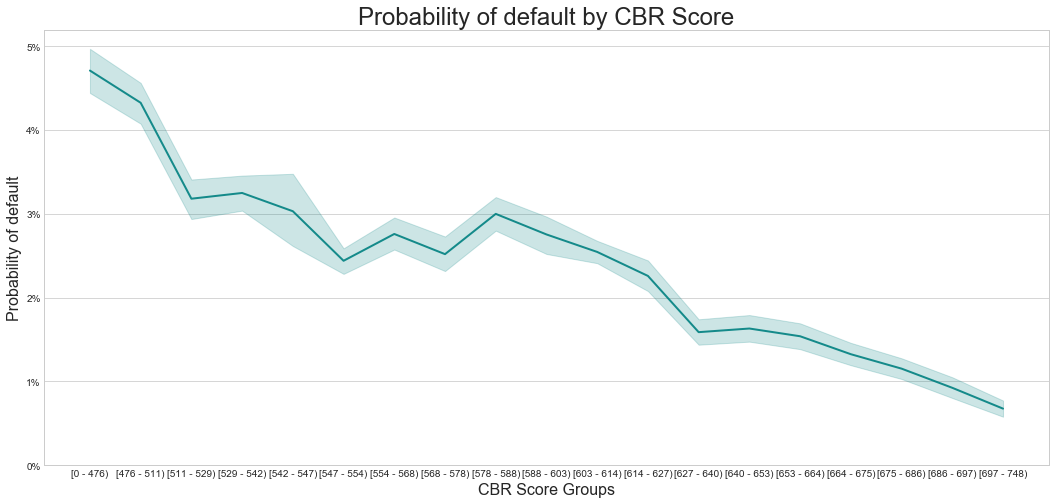

In [16]:
lineplot(df, 
         'Probability of default by CBR Score', 
         'CBR Score Groups', 
         'Probability of default', 
         'CRBScoreBin', 
         'Default', 
         xticks=10,
         percent=True)

In general **'Credit Rating Bureau score'** is predictive and the higher the score, the lower the probability of default is. But also score has bad discriminative power between **542** and **588**, where the probability of default is not monotone.

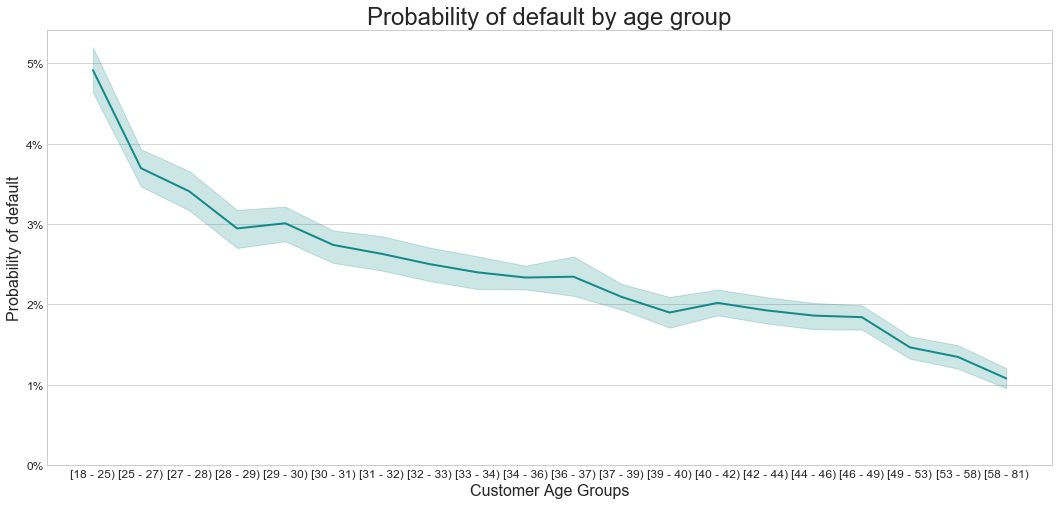

In [17]:
lineplot(df, 
         'Probability of default by age group', 
         'Customer Age Groups', 
         'Probability of default', 
         'AgeBin', 
         'Default', 
         xticks=12,
         percent=True)

Across these **age groups** probability of default varies between approximately from **1%** to **5%**.  
In general probability of default is lower in older age groups.

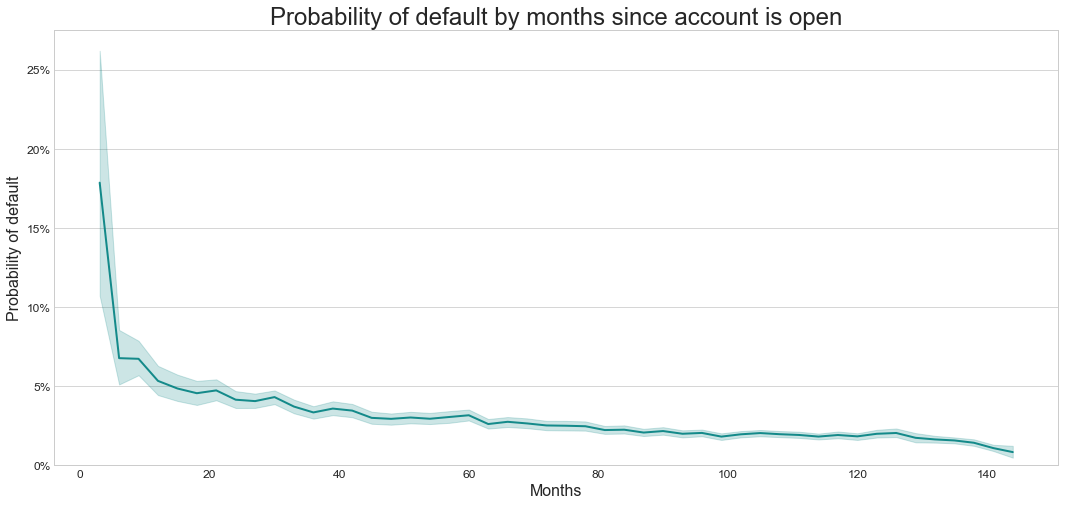

In [18]:
lineplot(df, 
         'Probability of default by months since account is open', 
         'Months', 
         'Probability of default', 
         'MonthsSinceOpenBin', 
         'Default', 
         xticks=12,
         percent=True)

In [19]:
tmp = df.groupby('MonthsSinceOpen').Default.mean().reset_index(name='DefaultRate')
default_rate_more_10=tmp[tmp.DefaultRate>0.10]
default_rate_for_oldest_account=tmp.DefaultRate[tmp.MonthsSinceOpen==tmp.MonthsSinceOpen.max()].sum()
default_rate_more_10

,MonthsSinceOpen,DefaultRate
0,4.0,0.240000
1,5.0,0.152542


Recently joined customers (account is opened 4 or 5 months ago) exibit considerably higher probability of default, between 15% and 24%. 
If the account is older than 2 years, the probability of default is under 5% and monotonically decreases further. 
The oldest account was opened 12 years ago and it dafault rate is {{round(default_rate_for_oldest_account*100,2)}}%.

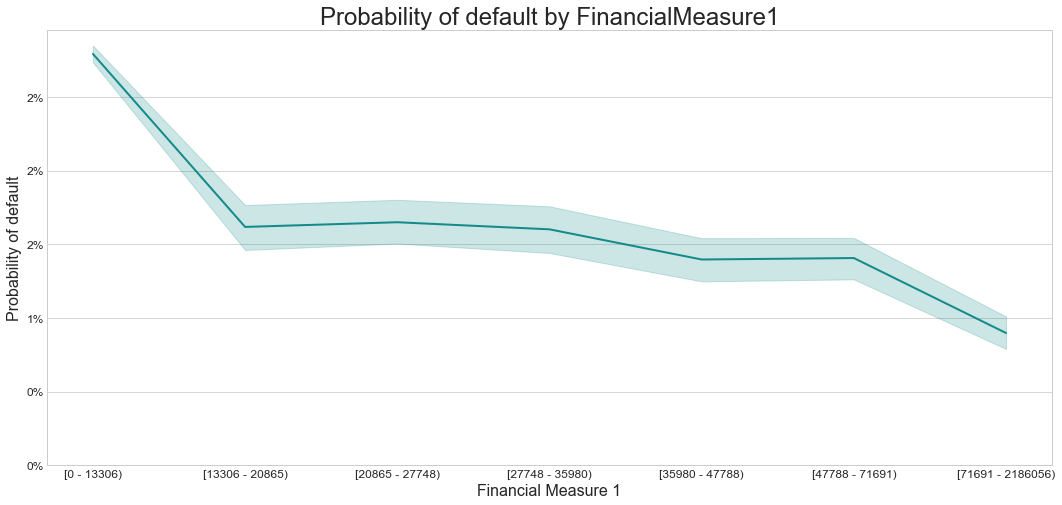

In [20]:
lineplot(df, 
         'Probability of default by FinancialMeasure1', 
         'Financial Measure 1', 
         'Probability of default', 
         'FinancialMeasure1Bin', 
         'Default', 
         xticks=12,
         percent=True)

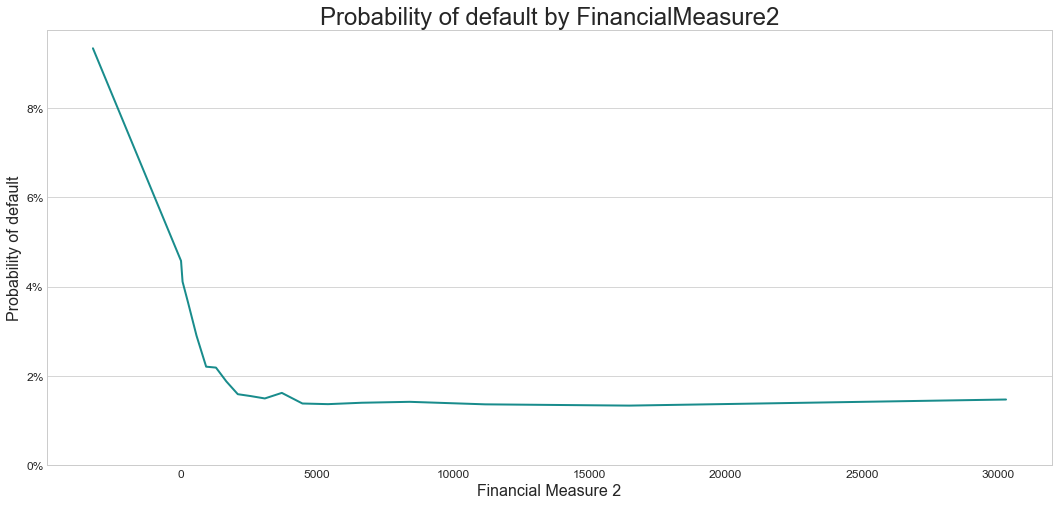

In [21]:
tmp = df.groupby('FinancialMeasure2Bin')
tmp = tmp.agg({'Default': 'mean', 'FinancialMeasure2': 'mean'})                                                                                                                            
tmp = tmp[tmp.FinancialMeasure2<40000]
lineplot(tmp, 
         'Probability of default by FinancialMeasure2', 
         'Financial Measure 2', 
         'Probability of default', 
         'FinancialMeasure2', 
         'Default', 
         xticks=12,
         percent=True)

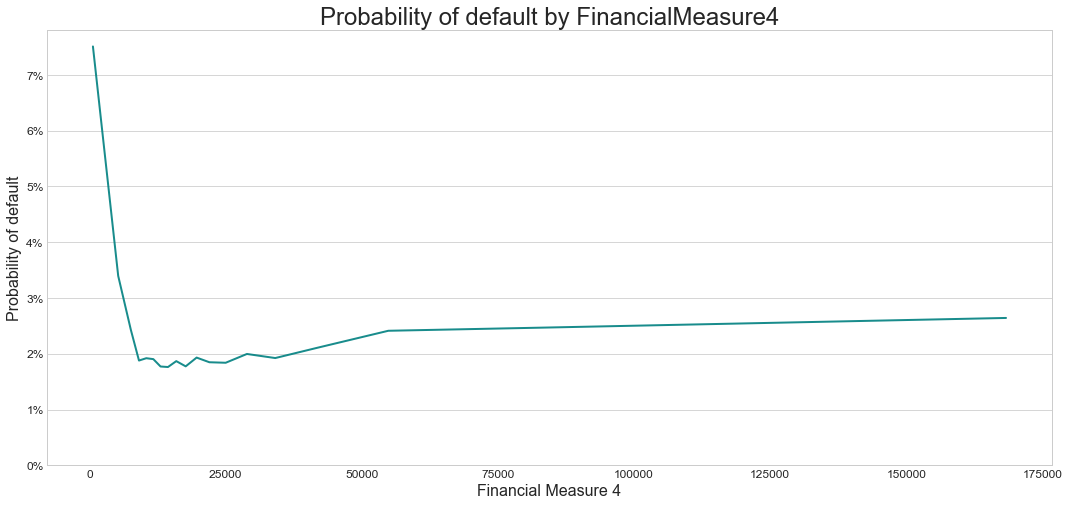

In [22]:
tmp = df.groupby('FinancialMeasure4Bin')
tmp = tmp.agg({'Default': 'mean', 'FinancialMeasure4': 'mean'})
tmp = tmp[tmp.FinancialMeasure4<=200000]
lineplot(tmp, 
         'Probability of default by FinancialMeasure4', 
         'Financial Measure 4', 
         'Probability of default', 
         'FinancialMeasure4',
         'Default', 
         xticks=12,
         percent=True)

All 3 financial measures show that the probability of default is high when the financial measure is small, and gradually decreases when financial measures increase.

# Feature engineering 

## Feature - day of the month

One potential new feature could be day of the month, when the loan was issued.  
**'DisbursementDay'** column is added to **'df'** dateset.

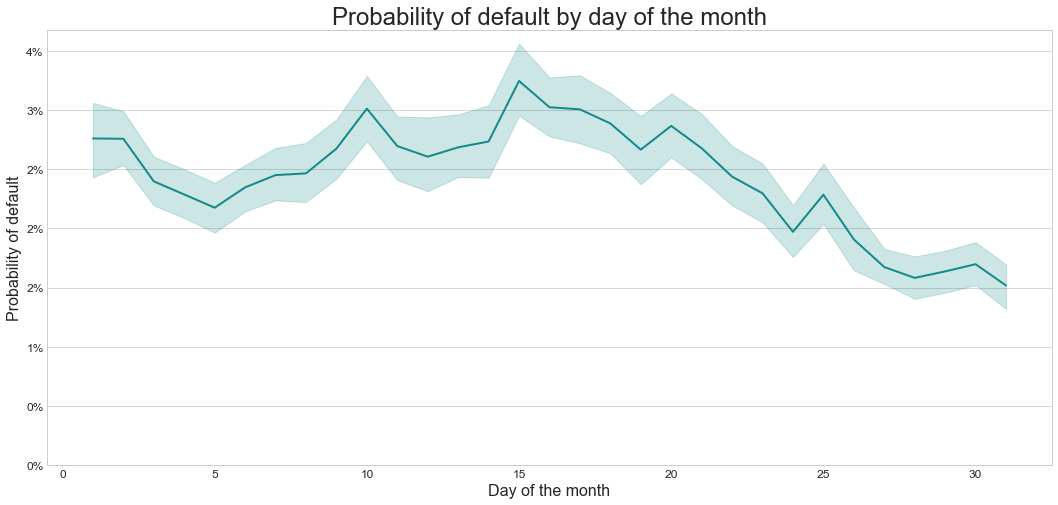

In [23]:
tmp = df.groupby('DisbursementDay').Default.mean().reset_index(name='DefaultRate')
lineplot(df, 
         'Probability of default by day of the month', 
         'Day of the month', 
         'Probability of default', 
         'DisbursementDay', 
         'Default',
         xticks=12,
         percent=True)

It appears that default rate differs significantly enough across different days to include this feature in consideration.

## Feature -  number of loans before

Another potential feature is number of loans issued previously to the same customer.  
**'PreviousLoans'** column is added to **'df'** dateset.

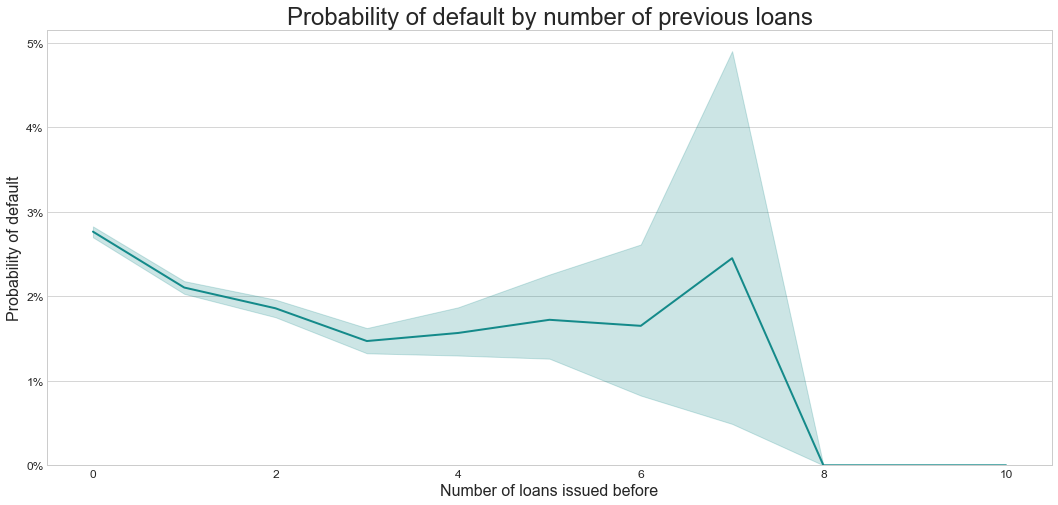

In [24]:
lineplot(df, 
         'Probability of default by number of previous loans', 
         'Number of loans issued before', 
         'Probability of default',
         'PreviousLoans', 
         'Default', xticks=12,
         percent=True)

Default rate goes down substantially with the number of loans customer has taken previously.

## Dataset transformation

**df** - dataset is cleaned using following steps:
* 11 rows with NA values are removed
* column 'DisbursementDate' type is changed from object to datetime
* column 'Age' - rows are removed, where age is above 18 and below 80 
* column 'CustomerType' - rows are removed, where type is 0 or 3
* column 'MonthsSinceActive' is deleted
* column 'AgeBin' is added ('Age' binning to 5% quantile)
* column 'CRBScoreBin' is added ('CRBScore' binning to 5% quantile)
* column 'MonthsSinceOpenBin' is added ('MonthsSinceOpen' binning by 3 months)
* column 'FinancialMeasure1Bin' is added ('FinancialMeasure1' binning to 5% quantile)
* column 'FinancialMeasure2Bin' is added ('FinancialMeasure2' binning to 5% quantile)
* column 'FinancialMeasure4Bin' is added ('FinancialMeasure4' binning to 5% quantile)
* column 'DisbursementDay' is added
* column 'PreviousLoans' is added

Row count: **{{len(df.index)}}**  
Column count: **{{len(df.columns)}}**   

|Column | Data Type |NaN value count|Description | Comment|
|:-----|:---------|--------|---|---|  
| Customer_WID | {{str(df.Customer_WID.dtypes)}} |{{df.Customer_WID.isna().sum()}} |Unique customer identifier |  |
| DisbursementDate | {{str(df.DisbursementDate.dtypes)}} |{{df.DisbursementDate.isna().sum()}}| Date, when loan was disbursed  ||
| Age | {{str(df.Age.dtypes)}} | {{df.Age.isna().sum()}}| Customer age  ||
| CustomerType | {{str(df.CustomerType.dtypes)}} | {{df.Age.isna().sum()}}|Internal customer type classification (1,2)||  
| SOR | {{str(df.SOR.dtypes)}} | {{df.SOR.isna().sum()}}|A metric of customer relationship with the bank ||   
| MonthsSinceOpen | {{str(df.MonthsSinceOpen.dtypes)}} | {{df.MonthsSinceOpen.isna().sum()}}|Number of months since first account for the customer  ||
| FinancialMeasure1 | {{str(df.FinancialMeasure1.dtypes)}} |{{df.FinancialMeasure1.isna().sum()}}| Some measure of financial activity of a customer  ||
| FinancialMeasure2 | {{str(df.FinancialMeasure2.dtypes)}} | {{df.FinancialMeasure2.isna().sum()}}|Some measure of financial activity of a customer  ||
| FinancialMeasure3 | {{str(df.FinancialMeasure3.dtypes)}} |{{df.FinancialMeasure3.isna().sum()}}| Some measure of financial activity of a customer ||
| FinancialMeasure4 | {{str(df.FinancialMeasure4.dtypes)}} | {{df.FinancialMeasure4.isna().sum()}}|Some measure of financial activity of a customer  ||
| CRBScore | {{str(df.CRBScore.dtypes)}} | {{df.CRBScore.isna().sum()}}|Credit rating bureau score  
| Amount | {{str(df.Amount.dtypes)}} |{{df.Amount.isna().sum()}}| Loan amount || 
| **Default** | {{str(df.Default.dtypes)}} |{{df.Default.isna().sum()}}| 1 - Defaulted on this loan, 0 - paid||
| AgeBin | {{str(df.AgeBin.dtypes)}} |{{df.AgeBin.isna().sum()}}| 'Age' binning to 5% quantile|
| CRBScoreBin | {{str(df.CRBScoreBin.dtypes)}} |{{df.CRBScoreBin.isna().sum()}}| 'CRBScore' binning to 5% quantile|
| MonthsSinceOpenBin | {{str(df.MonthsSinceOpenBin.dtypes)}} |{{df.MonthsSinceOpenBin.isna().sum()}}| 'MonthsSinceOpen' binning by 3 months|
| FinancialMeasure1Bin | {{str(df.FinancialMeasure1Bin.dtypes)}} |{{df.FinancialMeasure1Bin.isna().sum()}}| 'FinancialMeasure1' binning to 5% quantile|
| FinancialMeasure2Bin | {{str(df.FinancialMeasure2Bin.dtypes)}} |{{df.FinancialMeasure2Bin.isna().sum()}}| 'FinancialMeasure2' binning to 5% quantile|
| FinancialMeasure3Bin | {{str(df.FinancialMeasure4Bin.dtypes)}} |{{df.FinancialMeasure4Bin.isna().sum()}}| 'FinancialMeasure4' binning to 5% quantile|
| DisbursementDay | {{str(df.DisbursementDay.dtypes)}} |{{df.DisbursementDay.isna().sum()}}| Day of the month, when the loan was issued|
| PreviousLoans | {{str(df.PreviousLoans.dtypes)}} |{{df.PreviousLoans.isna().sum()}}| Loans issued previously to the same customer|

## Split dataset to test and train 
**Train/Test** split will be done in proportion of **70%/30%** and **stratified** on **'Default'** column.  
**X_train** and **X_test** contain columns {{list(X_train.columns)}}.  
**y_train** and **y_test** contain column '{{y_train.name}}'.

## Weight of evidence transformation

Weight of evidence transformation is a way to bin continuous variables and introduce non-linearity to linear or GLM model.  
It is done in two steps, first variable is split into fine classes (usually into 20-40 classes by quantiles) and then adjacent classes are merged if they have similar weight of evidence value. Weight of evidence value is calculated as 
\begin{equation*}
\mathbf{WOE} =\mathbf{\displaystyle{ln}}\Bigl(\frac{\%\ of\ non-events}{\%\ of\ events}\Bigr)
\end{equation*}

Since weight of evidence transformation of covariates is done by measuring their influence on dependent variable, this transformation should be estimated on train dataset to prevent data leakage from test dataset.  

Columns for woe transformations: 'Age', 'MonthsSinceOpen', 'FinancialMeasure1', 'FinancialMeasure2',
'FinancialMeasure4', 'CRBScore','PreviousLoans','DisbursementDay'.

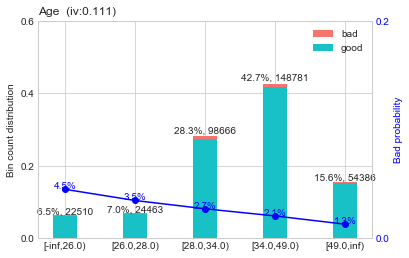

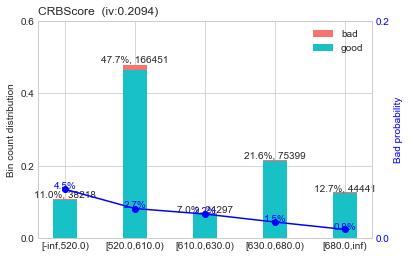

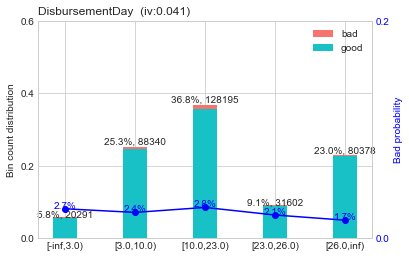

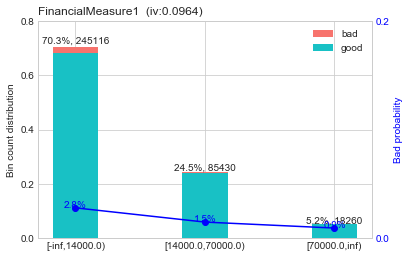

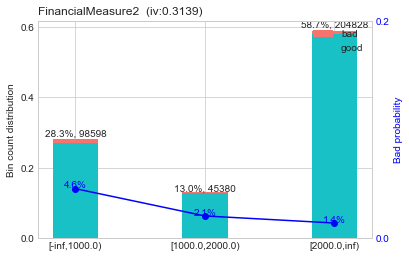

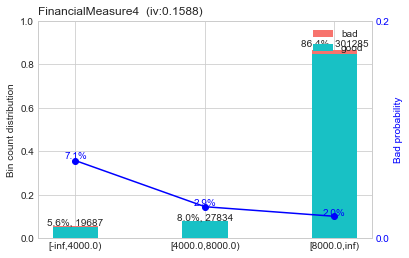

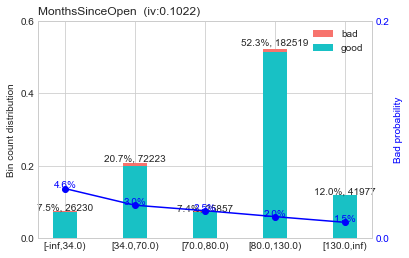

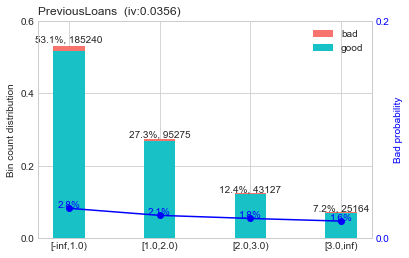

In [25]:
sc.woebin_plot(WOE.optimal_bin)
plt.show()

# Feature selection

**List of features, which are included models:**  
* **'Age'** - analysis of Age and Default interactions showed a significant negative correlation trend, older customers have lower probability of default.   
* **'CustomerType'** - customer segmentation, which is important for business strategy and thus remains in the dataset. In addition average default rate for customer type 1 is lower than for customer type 2.  
* **'SOR'** - measure of customer loyalty with the bank. Correlation analysis showed that this measure correlates strongly with average loan amount, but not so much with Default.  
* **'MonthsSinceOpen'** - number of months with the bank. Analysis showed that the longer the customer is loyal to the bank, the lower their probability of default.  
* **'FinancialMeasure1', 'FinancialMeasure2', 'FinancialMeasure4'** - financial measures of customer activity, could be balance or transactional volume. Analysis showed a significant negative correlation: with increase of financial measures probability of default goes down.  
* **'CRBScore'** - primary benchmark to beat, a credit rating bureau score. The most predictive column in the dataset.  
* **'PreviousLoans'** - number of previous loans, first time loan customers showed to be riskier, than repeat customers.
* **'DisbursementDay'** - loan disbursement day of month. End of month days show lower probability of default.  

These features were selected based on exploratory analysis done in the prior sections. 
Variable 'FinancialMeasure3' was excluded from further modeling due to very high correlation with 'FinancialMeasure4'. 
Variable 'Amount' was excluded from modeling, bevause it is typically unknown prior to loan application.  

In addition for Logistic and Linear models, features were Weight of Evidence transformed. Random forest and Gradient boosted trees are trained using original values, because these algorithms dont benefit from such transformation.

# Modeling 

## Linear Regression model

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable.
Multiple linear regression is a generalization of simple linear regression to the case of more than one independent variable, and a special case of general linear models, restricted to one dependent variable [1]. 

**Formula:**  
$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon},$ where  
* $\mathbf {y}$ is a vector of observed values $\displaystyle{y}_{i} (i=1, \ldots, \displaystyle{n})$  of the variable called the dependent variable or predicted variable.  
* $\mathbf{X}$ may be seen as a matrix of row-vectors $\displaystyle{x} _{i}$ or of n-dimensional column-vectors $\displaystyle X_{j}$.  
* $\boldsymbol {\beta }$ is a $\displaystyle (p+1)$-dimensional parameter vector, where $\displaystyle \beta _{0}$ is the intercept term. Its elements are effects or regression coefficients.
* $\boldsymbol{\varepsilon}$ is a vector of values $\displaystyle\varepsilon _{i}$ is called the error term or noise.

**Steps:**
* Initialize linear regression class from sklearn 
* Training model on wight of evidence transformed dataset
* Estimate default probability on test dataset.

In [26]:
linear_model = LinearRegression()
linear_model.fit(WOE.x_train_woe, Dataset.y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
y_predict_lm = linear_model.predict(WOE.x_test_woe)

**$\displaystyle \beta _{0}$** - Trained model intercept: {{round(linear_model.intercept_.sum(),7)}} 

**$\displaystyle \beta _{i}$** $(i=0, \ldots, \displaystyle{9})$ -  Trained model coefficients:  
* '{{WOE.x_train_woe.columns\[0\]}}'  {{round(linear_model.coef_\[0\],7)}} - since number is negative, therefore as SOR grows, probability of default falls down
* '{{WOE.x_train_woe.columns\[1\]}}'  {{round(linear_model.coef_\[1\],7)}} - since number is positive, therefore customer type '2' has higher probability of default
* '{{WOE.x_train_woe.columns\[2\]}}'  {{round(linear_model.coef_\[2\],7)}}
* '{{WOE.x_train_woe.columns\[3\]}}'  {{round(linear_model.coef_\[3\],7)}}
* '{{WOE.x_train_woe.columns\[4\]}}'  {{round(linear_model.coef_\[4\],7)}}
* '{{WOE.x_train_woe.columns\[5\]}}'  {{round(linear_model.coef_\[5\],7)}}
* '{{WOE.x_train_woe.columns\[6\]}}'  {{round(linear_model.coef_\[6\],7)}}
* '{{WOE.x_train_woe.columns\[7\]}}'  {{round(linear_model.coef_\[7\],7)}}
* '{{WOE.x_train_woe.columns\[8\]}}'  {{round(linear_model.coef_\[8\],7)}}
* '{{WOE.x_train_woe.columns\[9\]}}'  {{round(linear_model.coef_\[9\],7)}}

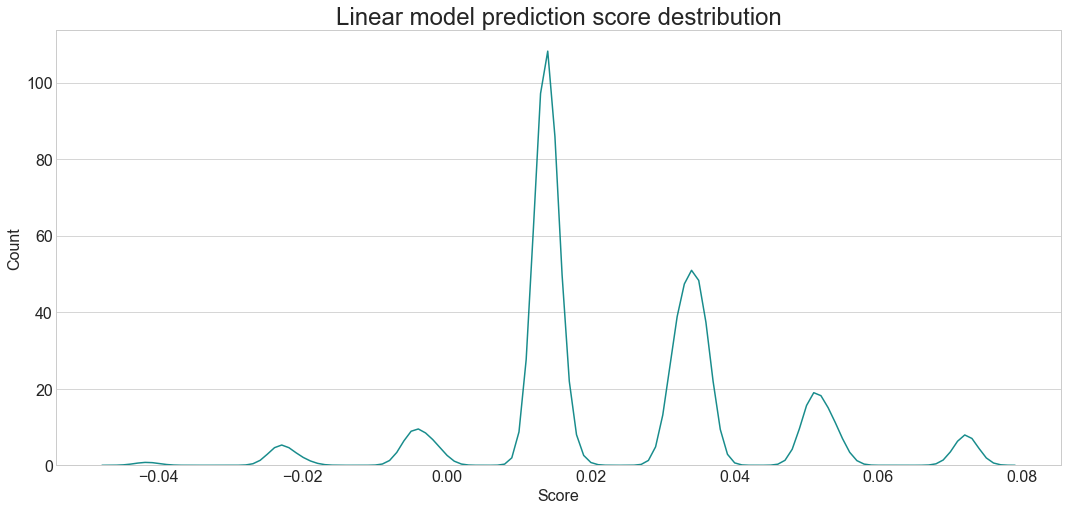

In [28]:
kdeplot(y_predict_lm,
        'Linear model prediction score destribution',
        'Score',
        'Count')

The chart above shows distribution of scores produced by fitted linear regression on test dataset.  
Score distribution is multi-modal, which is not ideal for credit scores.

The following chart shows sampled AUC on train and test during cross validation with 20 folds.

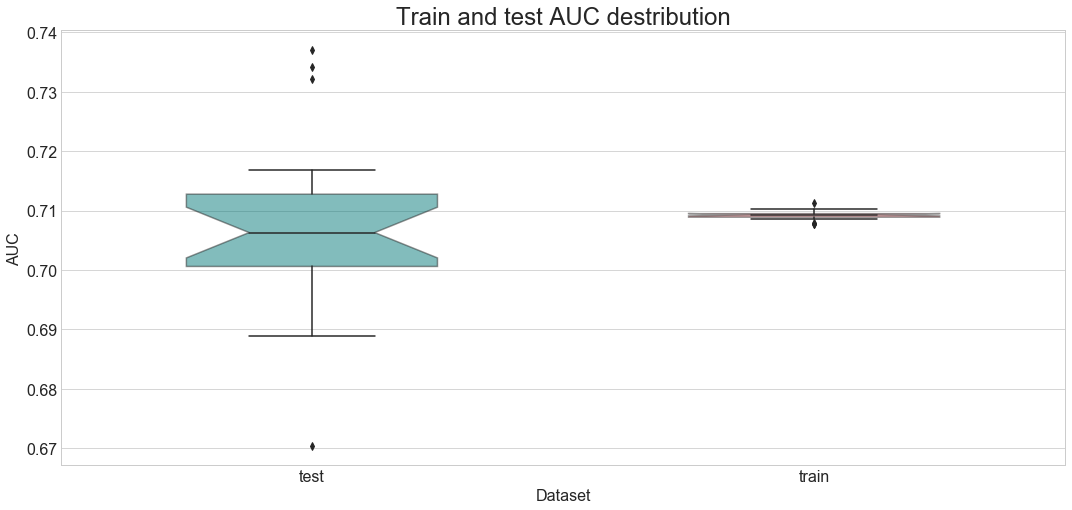

In [29]:
scores = cross_validate(linear_model, WOE.x_train_woe, Dataset.y_train, scoring=['roc_auc'], 
                        cv = 20, return_train_score=True)

tmp_test = pd.DataFrame({'dataset': 'test','score':scores['test_roc_auc']})
auc_test_median_linear = tmp_test.score.median()
auc_test_std_linear = tmp_test.score.std()
tmp_train = pd.DataFrame({'dataset': 'train','score':scores['train_roc_auc']})
auc_train_median_linear = tmp_train.score.median()
auc_train_std_linear = tmp_train.score.std()
tmp = pd.concat([tmp_test, tmp_train])

auc_df_linear = pd.DataFrame({'Values': [auc_test_median_linear,
                                         auc_test_std_linear,
                                         auc_train_median_linear,
                                         auc_train_std_linear]})
boxplot(tmp,
        'dataset',
        'score',
        'Train and test AUC destribution',
        'Dataset',
        'AUC')

Chart shows that fitted regression is not ovefit as median AUC scores of the model on train and test data are quite close.

## Logistic regression model

Logistic regression model uses a logistic function. Logistic regression analyzes the association between a categorical dependent variable and a set of independent (explanatory) variables. The name multinomial logistic regression is the case when the dependent variable has three or more unique values.

**Steps:**
* Initialize logistic regression class from sklearn 
* Training model on wight of evidence transformed dataset
* Estimate default probability on test dataset.

In [30]:
log_model = LogisticRegression(solver ='lbfgs',max_iter = 1000)
log_model.fit(WOE.x_train_woe, Dataset.y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
y_predict_log = log_model.predict_proba(WOE.x_test_woe)[:,1]

**$\displaystyle \beta _{0}$** - Trained model intercept: {{round(log_model.intercept_.sum(),7)}} 

**$\displaystyle \beta _{i}$** $(i=0, \ldots, \displaystyle{9})$ -  Trained model coefficients:  
* '{{WOE.x_train_woe.columns\[0\]}}'  {{round(log_model.coef_\[0\]\[0\],7)}} - since number is negative, therefore as SOR grows, probability of default falls down
* '{{WOE.x_train_woe.columns\[1\]}}'  {{round(log_model.coef_\[0\]\[1\],7)}} -since number is positive, therefore customer type '2' has higher probability of default
* '{{WOE.x_train_woe.columns\[2\]}}'  {{round(log_model.coef_\[0\]\[2\],7)}}
* '{{WOE.x_train_woe.columns\[3\]}}'  {{round(log_model.coef_\[0\]\[3\],7)}}
* '{{WOE.x_train_woe.columns\[4\]}}'  {{round(log_model.coef_\[0\]\[4\],7)}}
* '{{WOE.x_train_woe.columns\[5\]}}'  {{round(log_model.coef_\[0\]\[5\],7)}}
* '{{WOE.x_train_woe.columns\[6\]}}'  {{round(log_model.coef_\[0\]\[6\],7)}}
* '{{WOE.x_train_woe.columns\[7\]}}'  {{round(log_model.coef_\[0\]\[7\],7)}}
* '{{WOE.x_train_woe.columns\[8\]}}'  {{round(log_model.coef_\[0\]\[8\],7)}}
* '{{WOE.x_train_woe.columns\[9\]}}'  {{round(log_model.coef_\[0\]\[9\],7)}}

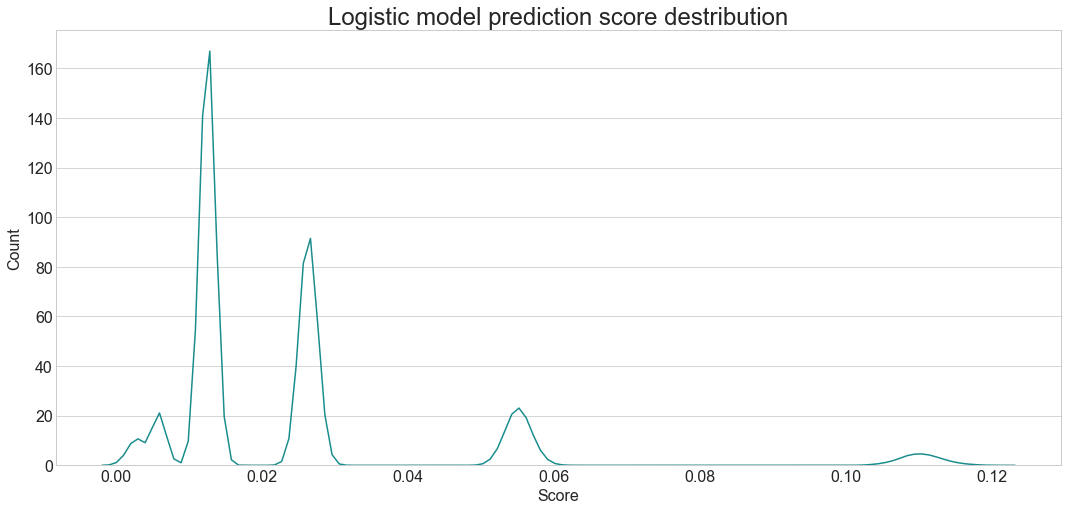

In [32]:
kdeplot(y_predict_log,
        'Logistic model prediction score destribution',
        'Score',
        'Count')

The chart above shows distribution of scores produced by fitted logistic regression on test dataset.  
Score distribution is multi-modal, but is better than linear regression.

The following chart shows sampled AUC on train and test during cross validation with 20 folds.

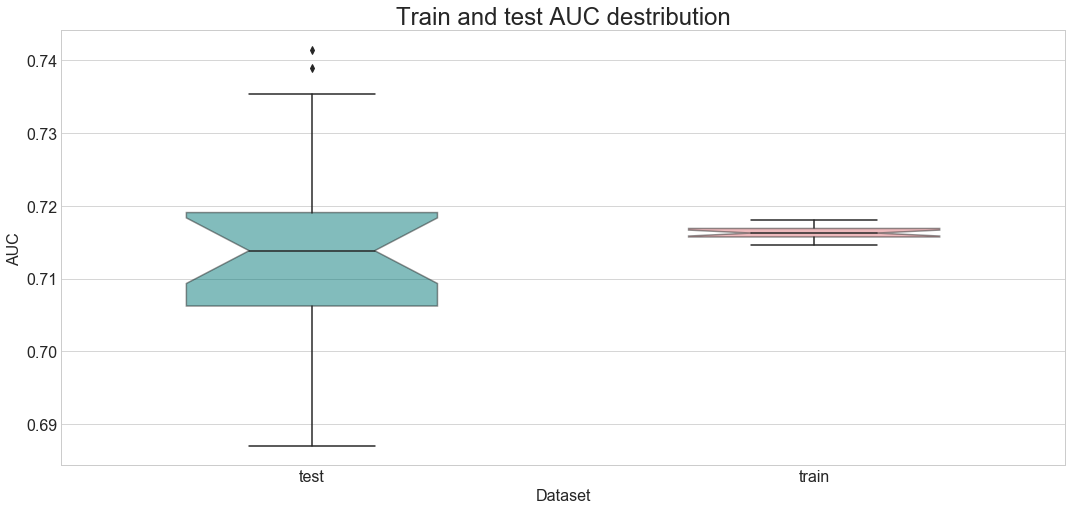

In [33]:
scores = cross_validate(log_model, WOE.x_train_woe, Dataset.y_train, scoring = ['roc_auc'], 
                        cv = 20, return_train_score = True)
tmp_test = pd.DataFrame({'dataset': 'test','score':scores['test_roc_auc']})
auc_test_median_log = tmp_test.score.median()
auc_test_std_log = tmp_test.score.std()
tmp_train = pd.DataFrame({'dataset': 'train','score':scores['train_roc_auc']})
auc_train_median_log = tmp_train.score.median()
auc_train_std_log = tmp_train.score.std()
tmp = pd.concat([tmp_test, tmp_train])

auc_df_log = pd.DataFrame({'Values': [auc_test_median_log,
                                      auc_test_std_log,
                                      auc_train_median_log,
                                      auc_train_std_log]})

boxplot(tmp,
        'dataset',
        'score',
        'Train and test AUC destribution',
        'Dataset',
        'AUC')

Chart shows that fitted regression is not ovefit as median AUC scores of the model on train and test data are quite close.

## Random Forest model

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting [2]. 

**Steps:**
* Considering long required training process for Random Forest model, it has been trained separately using 'code_source/model/randomdorest.py' and result has been saved to 'random_forest.model'.  
Parameters for model training:
    * The number of trees in the forest - 200
    * The maximum depth of the tree - 5
    * The minimum number of samples required to split an internal node - 500
    * The number of jobs to run in parallel - using all processors
    
* Estimate default probability on test dataset has been saved to 'y_predict_proba_rf.array'.

In [34]:
random_forest = pickle.load(open(absolute_path('random_forest.model'), 'rb'))
y_predict_rf = pickle.load(open(absolute_path('y_predict_proba_rf.array'), 'rb'))

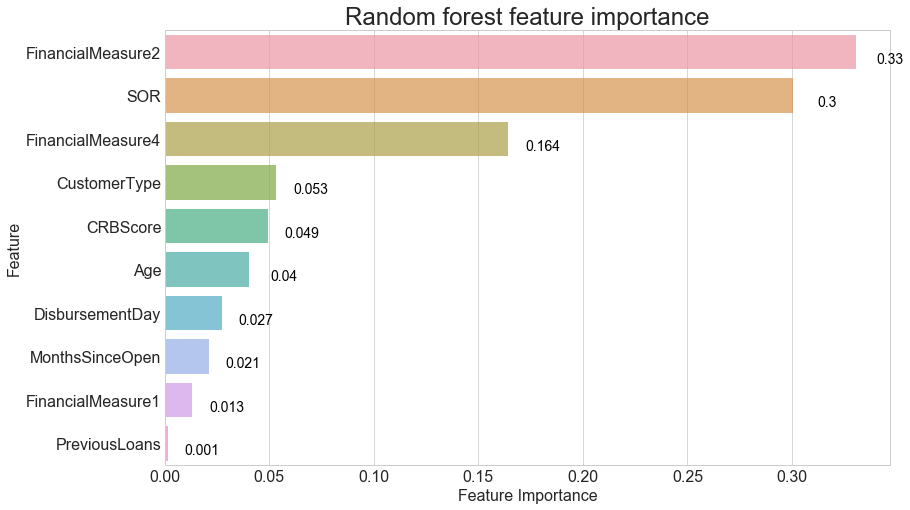

In [35]:
tmp = pd.DataFrame({'Feature': list(Dataset.X_train.columns),
                    'Score': random_forest.feature_importances_}) \
                    .sort_values(by=['Score'], ascending=False).reset_index()
barplot(tmp, 
        'Score',
        'Feature', 
        'Random forest feature importance', 
        'Feature Importance', 
        'Feature',
        figsize=(13, 8), 
        labels=False, 
        horizontallabels=True)

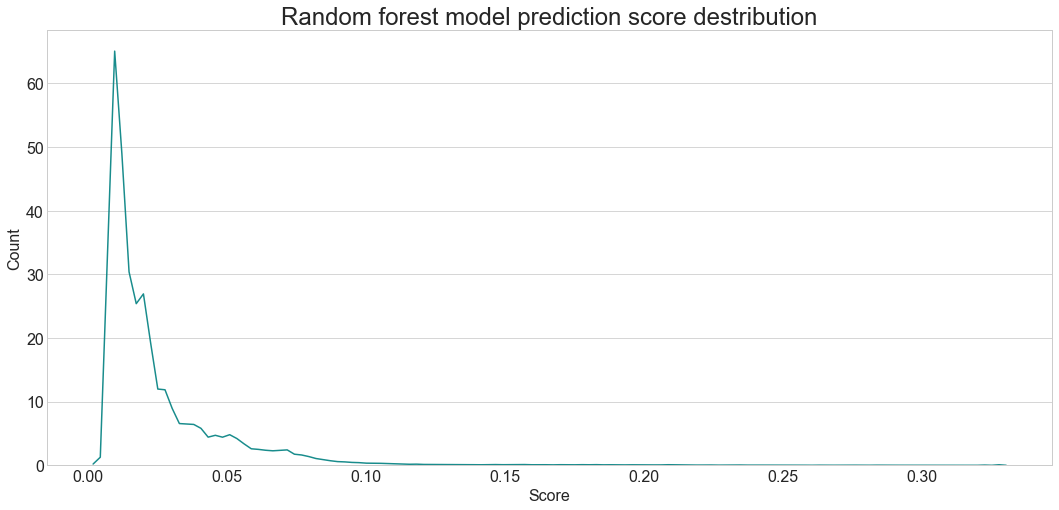

In [36]:
kdeplot(y_predict_rf,
        'Random forest model prediction score destribution',
        'Score',
        'Count')

The score distribution above looks like it has one mode, but wider range of possible values incomparison with SVM models

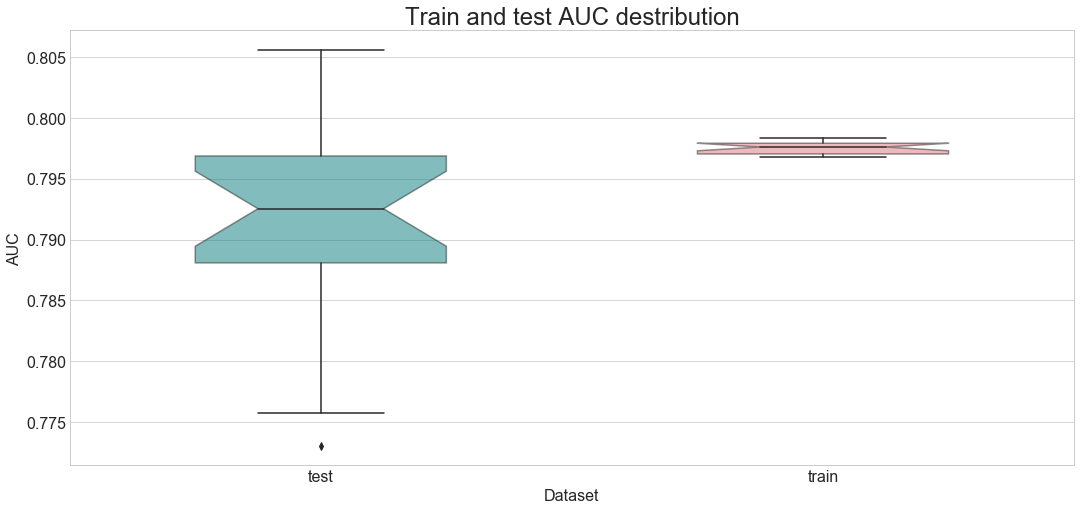

In [37]:
tmp = pickle.load(open(absolute_path('cross_validate_rf.dataframe'), 'rb'))
boxplot(tmp,
        'dataset',
        'score',
        'Train and test AUC destribution',
        'Dataset',
        'AUC')

It appears that Random Forest is a bit overfit on train dataset, since the difference in AUC between train and test scores is around 0.01. Still, it performs better than previous methods on test. 

## Gradient Boosting Classifier model

Gradient Boosting builds an additive model in a forward stage-wise fashion. It allows for the optimization of arbitrary differentiable loss functions [3]. 

**Steps:**
* Considering long required training process for Gradient Boosting Classifier model, it has been trained separately using 'code_source/model/gradientboosting.py' and result has been saved to 'gradient_boosting.model'.  
Parameters for model training:
    * The learning rate shrinks the contribution of each tree - 0.1
    * The number of boosting stages to perform - 200
    * The fraction of samples to be used for fitting the individual base learners - 0.5
    * The maximum depth of the individual regression estimators - 5
* Estimate default probability on test dataset has been saved to 'y_predict_proba_gb.array'.

In [38]:
gradient_boosting = pickle.load(open(absolute_path('gradient_boosting.model'), 'rb'))
y_predict_gb = pickle.load(open(absolute_path('y_predict_proba_gb.array'), 'rb'))

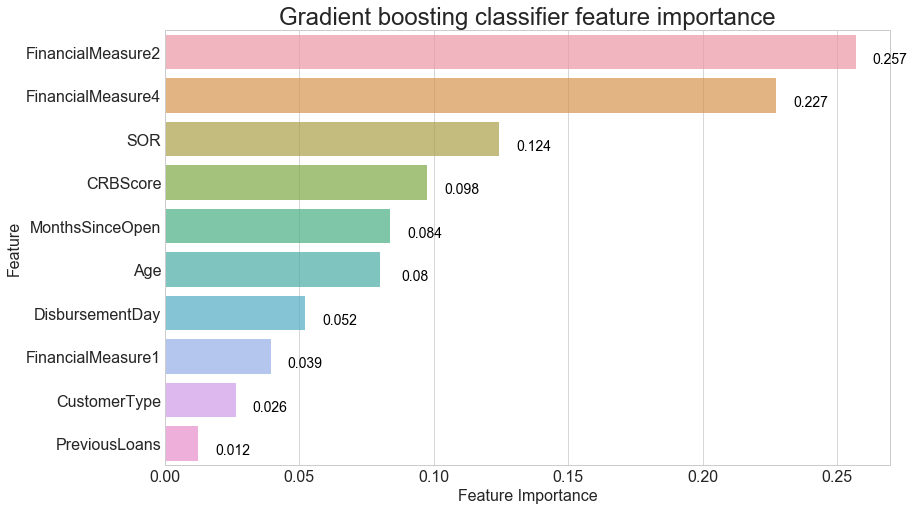

In [39]:
tmp = pd.DataFrame({'Feature': list(Dataset.X_train.columns),
                    'Score': gradient_boosting.feature_importances_}) \
                    .sort_values(by=['Score'], ascending=False).reset_index()
barplot(tmp, 
        'Score',
        'Feature', 
        'Gradient boosting classifier feature importance', 
        'Feature Importance', 
        'Feature',
        figsize=(13, 8), 
        labels=False, 
        horizontallabels=True)

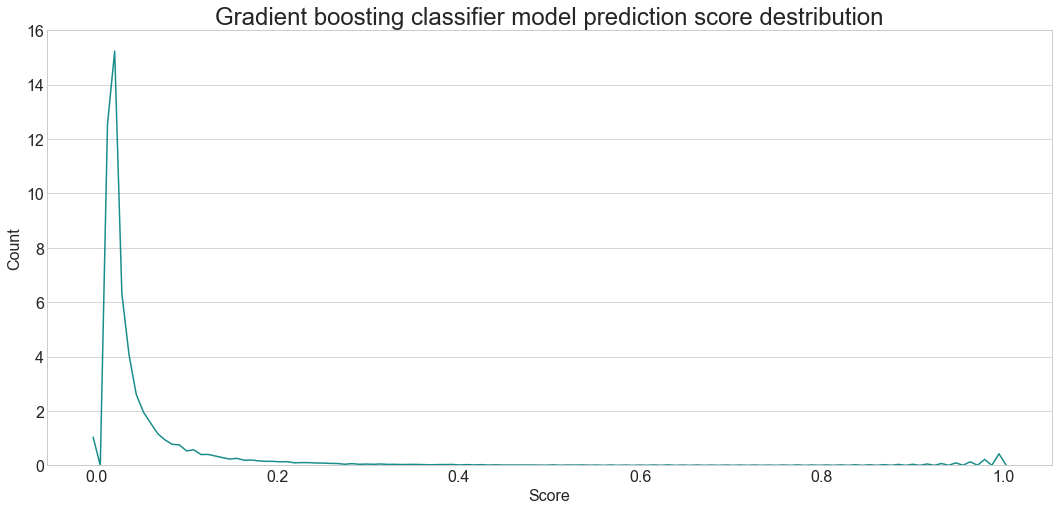

In [40]:
kdeplot(y_predict_gb,
        'Gradient boosting classifier model prediction score destribution',
        'Score',
        'Count')

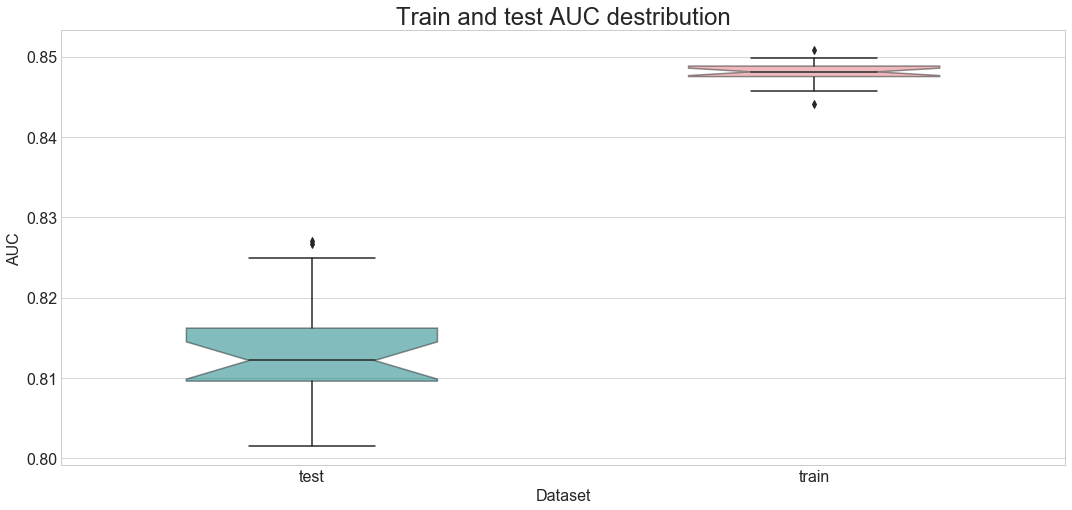

In [41]:
tmp = pickle.load(open(absolute_path('cross_validate_gb.dataframe'), 'rb'))
boxplot(tmp,
        'dataset',
        'score',
        'Train and test AUC destribution',
        'Dataset',
        'AUC')

It appears that Gradient boosting classifier is slightly overfit on train dataset, since the difference in AUC between train and test scores is around 0.04. Still, it performs better than previous methods on test. 

## XGBoost model

XGBoost model is an implementation of gradient boosted decision trees.

**Steps:**
* Transforme X_train and X_test withDMatrix
* Initialize XGBClassifier from xgboost 
* Training model on train dataset
Parameters for model training:
    * Boosting learning rate - 0.3
    * Maximum tree depth for base learners - 6
    * Number of trees to fit - 50
    
* Estimate default probability on test dataset.

In [42]:
X_train_xgb = xgb.DMatrix(Dataset.X_train, Dataset.y_train)
X_test_xgb = xgb.DMatrix(Dataset.X_test, Dataset.y_test)
xgb_model = XGBClassifier(learning_rate = 0.3, max_depth = 6, n_estimators = 50, verbosity = 0)
xgb_model.fit(Dataset.X_train, Dataset.y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=0)

In [43]:
y_predict_xgb = xgb_model.predict_proba(Dataset.X_test)[:,1]

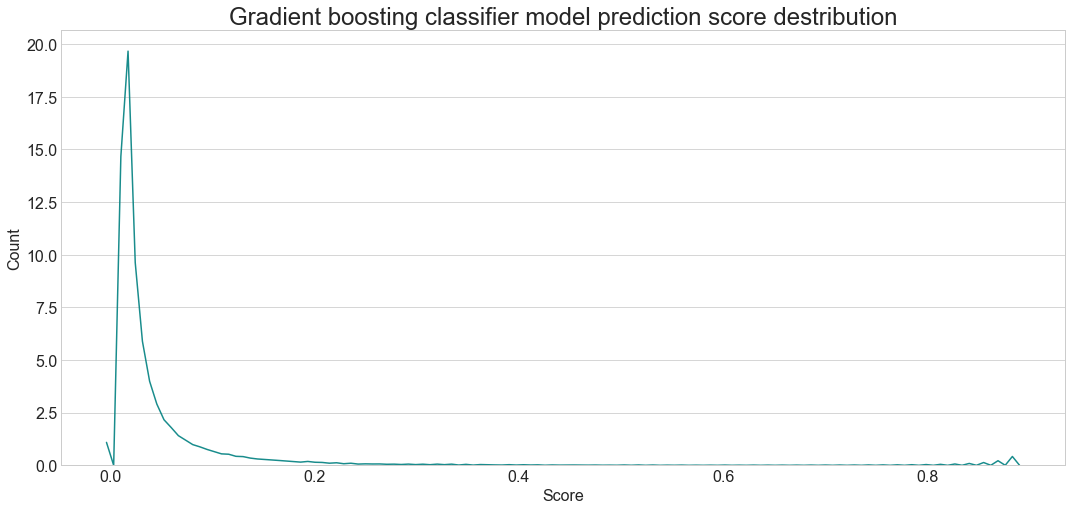

In [44]:
kdeplot(y_predict_xgb,
        'Gradient boosting classifier model prediction score destribution',
        'Score',
        'Count')

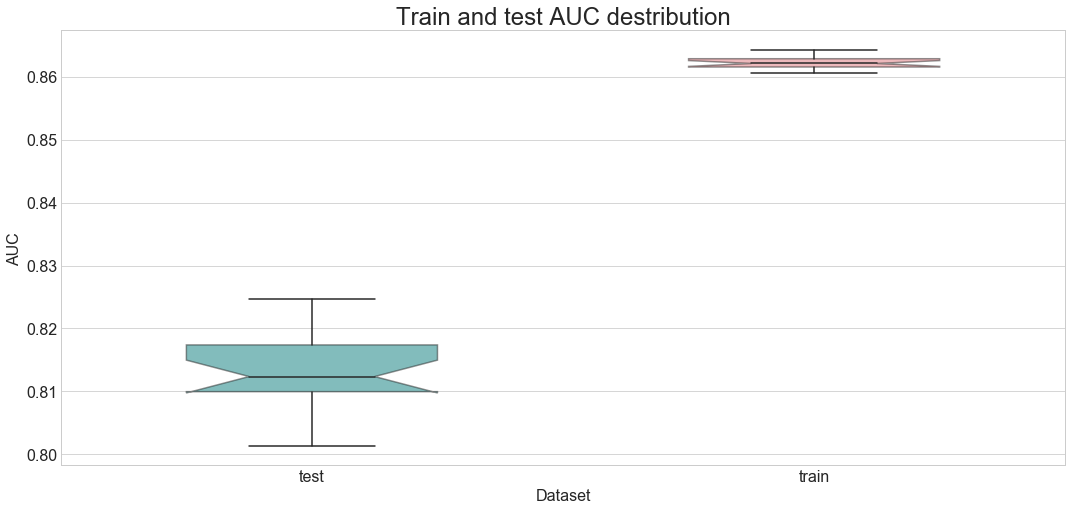

In [45]:
scores = cross_validate(xgb_model, Dataset.X_train, Dataset.y_train, scoring = ['roc_auc'], 
                        cv = 20, return_train_score = True)
tmp_test = pd.DataFrame({'dataset': 'test','score':scores['test_roc_auc']})
auc_test_median_log = tmp_test.score.median()
auc_test_std_log = tmp_test.score.std()
tmp_train = pd.DataFrame({'dataset': 'train','score':scores['train_roc_auc']})
auc_train_median_log = tmp_train.score.median()
auc_train_std_log = tmp_train.score.std()
tmp = pd.concat([tmp_test, tmp_train])

auc_df_xgb = pd.DataFrame({'Values': [auc_test_median_log,
                                      auc_test_std_log,
                                      auc_train_median_log,
                                      auc_train_std_log]})

boxplot(tmp,
        'dataset',
        'score',
        'Train and test AUC destribution',
        'Dataset',
        'AUC')

Xgboost is overfit on train dataset, the difference in AUC between train and test scores is around 0.05.

## Support Vector Machines model

Support Vector Machines are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier [4].

**Steps:**
* Before applying SVM model **Feature scaling (data normalization)** should be done.
    Method used to **standardize** the range of independent variables or features of data.  
    The standard score of a sample $\displaystyle{x}$ is calculated as: 
    \begin{equation*}
    \displaystyle{x}'=\frac{x-\bar{x}}{\sigma},\ where 
    \end{equation*}
    $\bar{x}$ - is the mean of the training samples  
    $\sigma$ - is the standard deviation of the training samples  

### SVC with linear kernel

* Considering long required training process for SVC model, it has been trained separately using **'code_source/model/svm.py'** and result has been saved to **svm_linear.model**.
* Estimate default probability on test dataset has been saved to **y_predict_proba_svm_linear.array**

In [46]:
svm_linear = pickle.load(open(absolute_path('svm_linear.model'), 'rb'))
y_predict_svm_linear = pickle.load(open(absolute_path('y_predict_proba_svm_linear.array'), 'rb'))

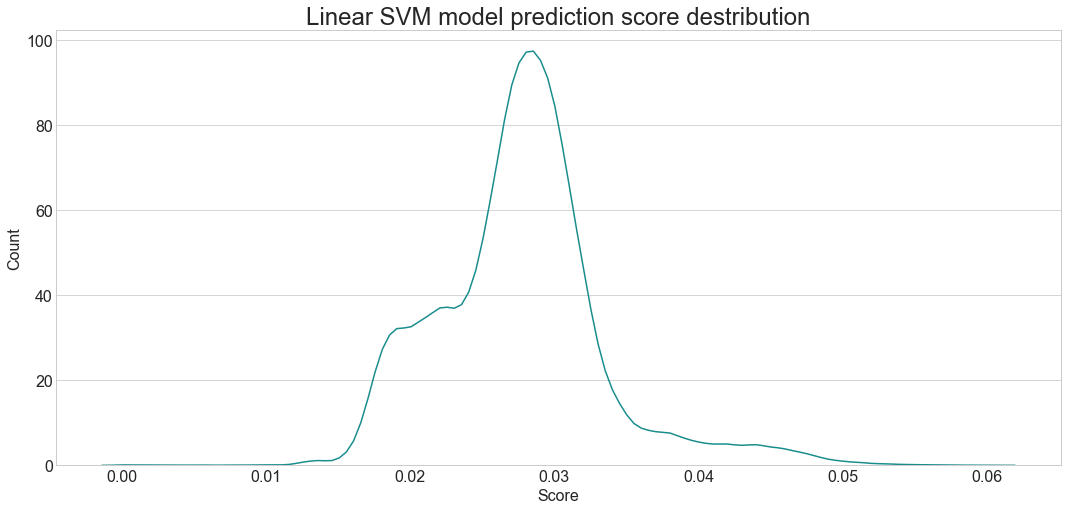

In [47]:
kdeplot(y_predict_svm_linear,
        'Linear SVM model prediction score destribution',
        'Score',
        'Count')

The score distribution above looks like it has one mode.

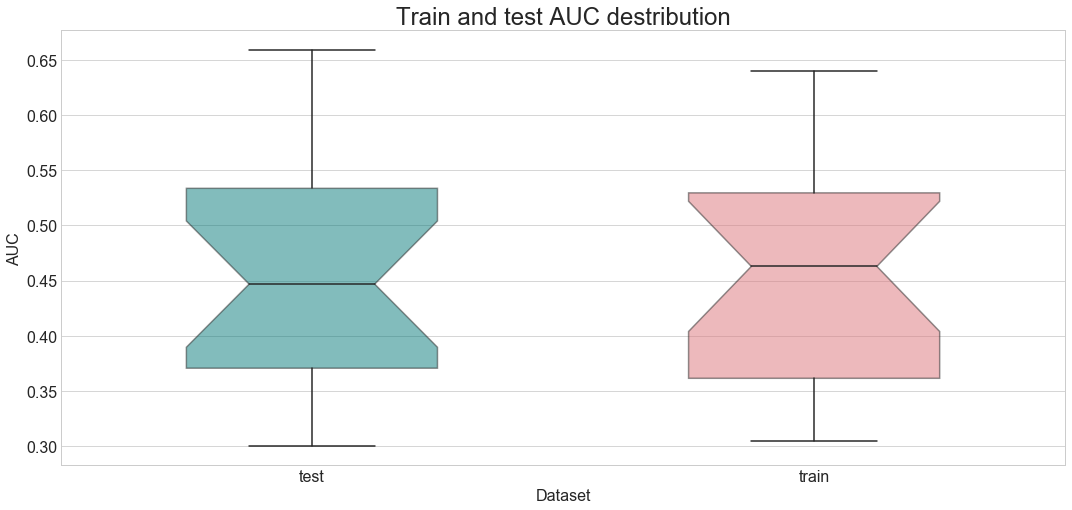

In [48]:
tmp = pickle.load(open(absolute_path('cross_validate_svm_linear.dataframe'), 'rb'))
boxplot(tmp,
        'dataset',
        'score',
        'Train and test AUC destribution',
        'Dataset',
        'AUC')

Chart shows that fitted regression is not ovefit as median AUC scores of the model on train and test data are quite close.

### SVC with Radial basis function (RBF) kernel

* Considering long required training process for SVC model, it has been trained separately using **'code_source/model/svm.py'** and result has been saved to **svm_rbf.model**.
* Estimate default probability on test dataset has been saved to **y_predict_proba_svm_rbf.array**

In [49]:
svm_rbf = pickle.load(open(absolute_path('svm_rbf.model'), 'rb'))
y_predict_svm_rbf = pickle.load(open(absolute_path('y_predict_proba_svm_rbf.array'), 'rb'))

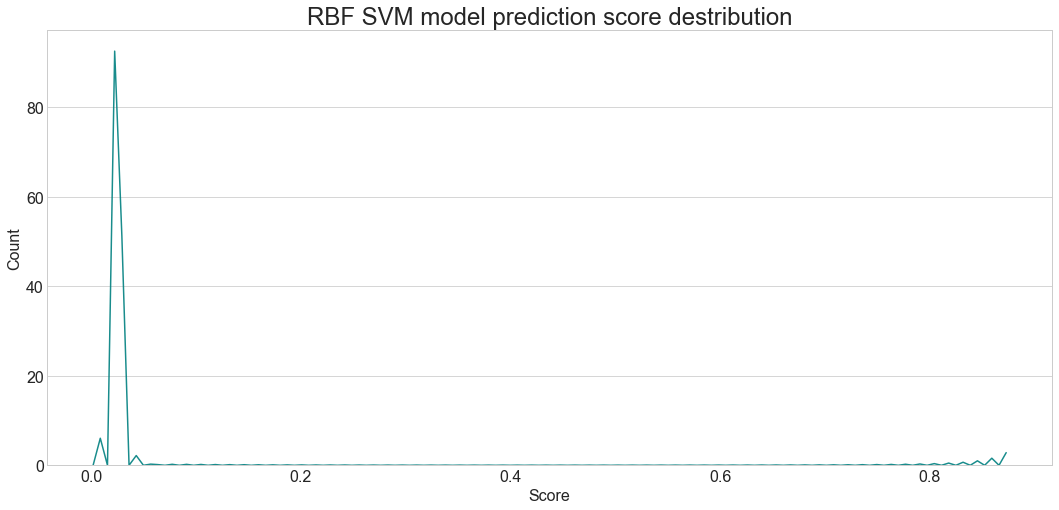

In [50]:
kdeplot(y_predict_svm_rbf,
        'RBF SVM model prediction score destribution',
        'Score',
        'Count') 

Prediction score is too concetreate in one area of the score.

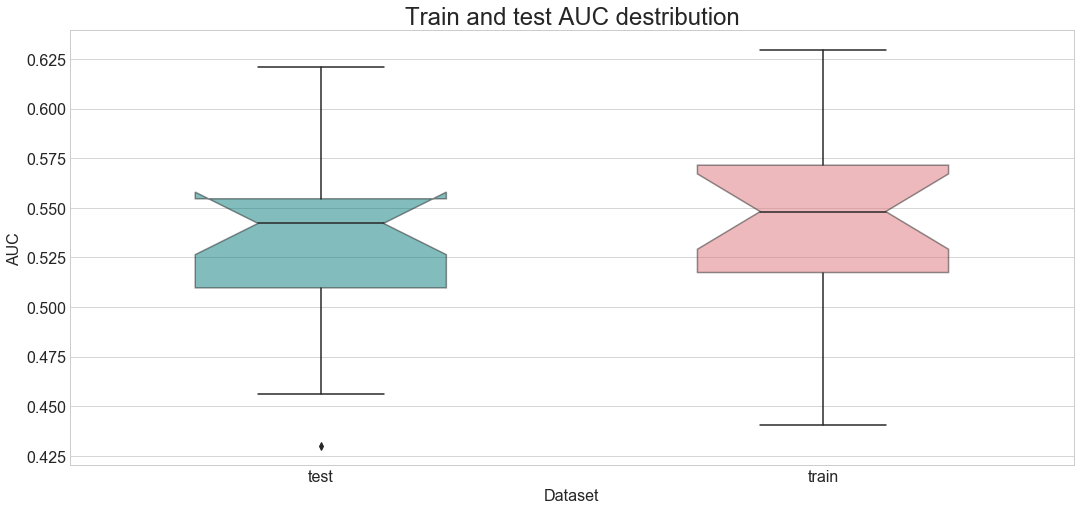

In [51]:
tmp = pickle.load(open(absolute_path('cross_validate_svm_rbf.dataframe'), 'rb'))
boxplot(tmp,
        'dataset',
        'score',
        'Train and test AUC destribution',
        'Dataset',
        'AUC')

Chart shows that fitted regression is not ovefit as median AUC scores of the model on train and test data are quite close.

### SVC with polynomial (degree 2) kernel

In [52]:
svm_poly = pickle.load(open(absolute_path('svm_poly.model'), 'rb'))
y_predict_svm_poly = pickle.load(open(absolute_path('y_predict_proba_svm_poly.array'), 'rb'))

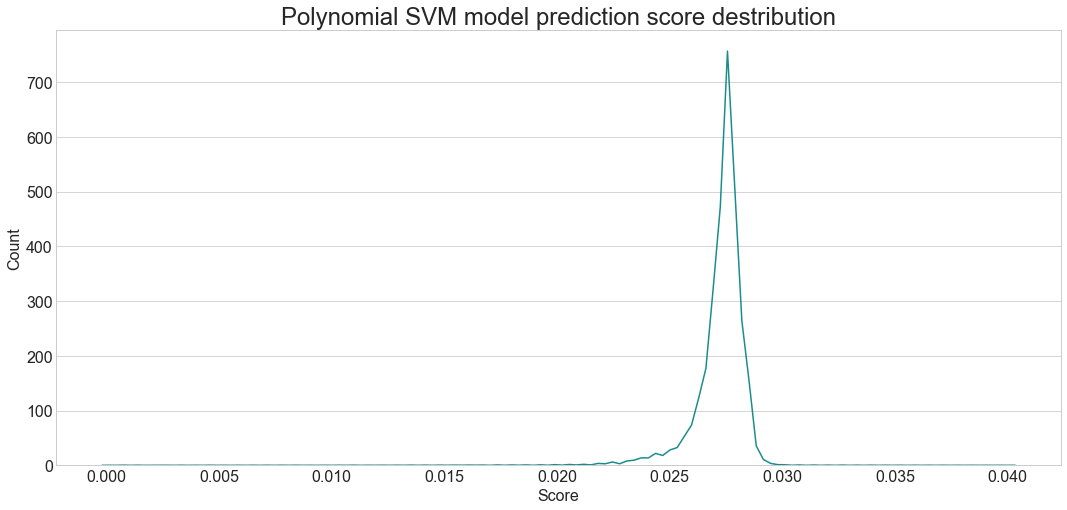

In [53]:
kdeplot(y_predict_svm_poly,
        'Polynomial SVM model prediction score destribution',
        'Score',
        'Count')

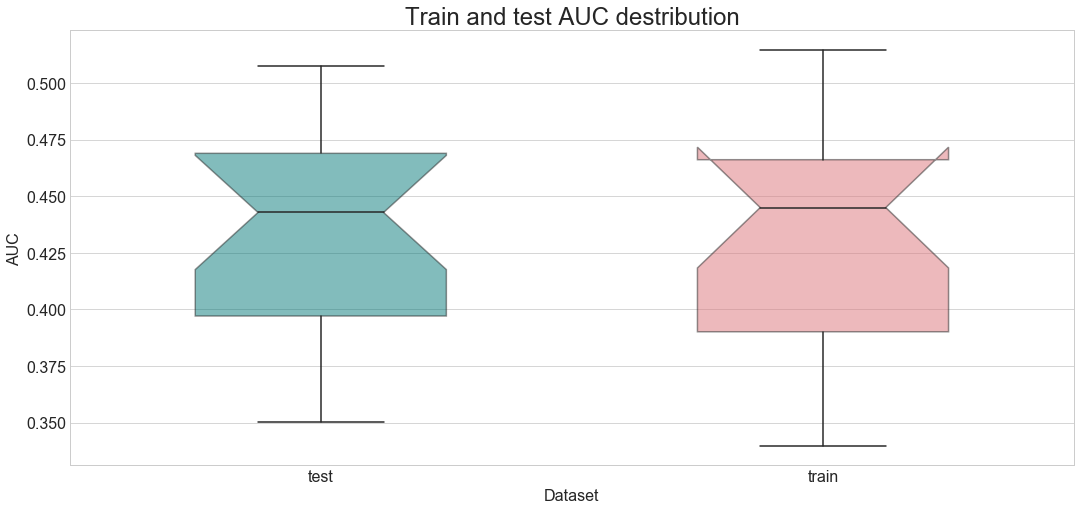

In [54]:
tmp = pickle.load(open(absolute_path('cross_validate_svm_poly.dataframe'), 'rb'))
boxplot(tmp,
        'dataset',
        'score',
        'Train and test AUC destribution',
        'Dataset',
        'AUC')

Chart shows that fitted regression is not ovefit as median AUC scores of the model on train and test data are quite close.

# Model evaluation 

For business model evaluation consider using the following information:  
* Loan application fee (paid only, when disbursed): **5%** of Amount   
* Annual interest rate: **13%**   
* When loan defaults, bank loses entire loaned amount. 

* Revenue formula:
\begin{equation*}
\mathbf{Revenue} =  Paid\ Loan\ Amount * \Bigl( \frac{13\%}{12} + 5\%\Bigr) - {Defaulted}\ Loan\ Amount
\end{equation*}

In [55]:
auc_rf_df = pickle.load(open(absolute_path('auc_rf.dataframe'), 'rb'))
auc_gb_df = pickle.load(open(absolute_path('auc_gb.dataframe'), 'rb'))
tmp = pd.concat([auc_df_linear.T, auc_df_log.T, auc_rf_df.T, auc_gb_df.T])
tmp = tmp.loc['Values']
tmp.columns = ['AUC median test', 'AUC std test', 'AUC median train', 'AUC std train']
tmp['Models']=['Linear regression', 'Logistic regression', 'Random forest','Gradient boosting classifier']
tmp = tmp[['Models', 'AUC std train', 'AUC std test', 'AUC median train', 'AUC median test']].loc['Values']
tmp.index = [0,1,2,3]
auc_std_median_df = tmp

AUC (area under the curve)
I will use AUC to determine which of the used models predicts the default best.  

{{auc_std_median_df}}

Using AUC metric the best clasifier is 'Gradient boosting classifier' becouse it shows higest median AUC value

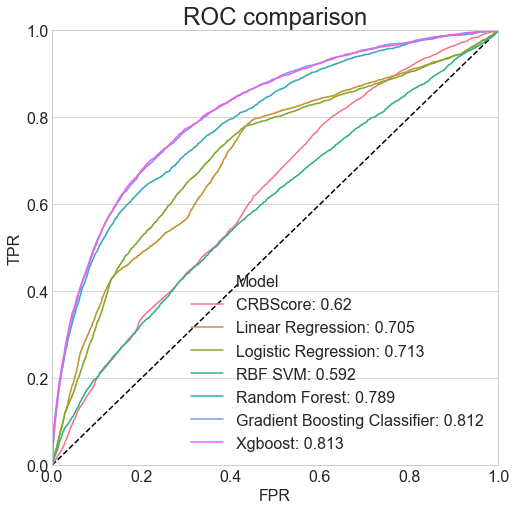

In [56]:
rocplot(y_test, 
        [-X_test.CRBScore, 
         y_predict_lm,
         y_predict_log,
         y_predict_svm_rbf,
         y_predict_rf,
         y_predict_gb,
         y_predict_xgb],
        ['CRBScore', 
         'Linear Regression',
         'Logistic Regression', 
         'RBF SVM',
         'Random Forest',
         'Gradient Boosting Classifier',
         'Xgboost'])

Apart from showing the highest AUC value 'Gradient boosting classifier' also outperforms other methods across the entire front of True Positive Rate and False Positive Rate

In [57]:
rev_lm = calculate_revenue_curve(Dataset.X_test, y_predict_lm, Dataset.y_test, Dataset.X_test_amount)
rev_log = calculate_revenue_curve(Dataset.X_test, y_predict_log, Dataset.y_test, Dataset.X_test_amount)
rev_svm_l = calculate_revenue_curve(Dataset.X_test, y_predict_svm_linear, Dataset.y_test, Dataset.X_test_amount)
rev_svm_rbf = calculate_revenue_curve(Dataset.X_test, y_predict_svm_rbf, Dataset.y_test, Dataset.X_test_amount)
rev_svm_poly = calculate_revenue_curve(Dataset.X_test, y_predict_svm_poly, Dataset.y_test, Dataset.X_test_amount)
rev_rf = calculate_revenue_curve(Dataset.X_test, y_predict_rf, Dataset.y_test, Dataset.X_test_amount)
rev_gb = calculate_revenue_curve(Dataset.X_test, y_predict_gb, Dataset.y_test, Dataset.X_test_amount)
rev_xgb = calculate_revenue_curve(Dataset.X_test, y_predict_xgb, Dataset.y_test, Dataset.X_test_amount)
rev_crb = calculate_revenue_curve(Dataset.X_test, -Dataset.X_test.CRBScore, Dataset.y_test, Dataset.X_test_amount)

In [58]:
rev_df = pd.DataFrame({'Model': ['CRB',
                                 'Linear Regression',
                                 'Logistic Regression',
                                 'Random Forest',
                                 'Gradient Boosting Classifier',
                                 'Xgboost',
                                 'Linear SVM',
                                 'RBF SVM',
                                 'Polynomial SVM',
                                ],
                       'RevenueTmp': [rev_crb.Revenue.max(), 
                                      rev_lm.Revenue.max(), 
                                      rev_log.Revenue.max(), 
                                      rev_rf.Revenue.max(),
                                      rev_gb.Revenue.max(),
                                      rev_xgb.Revenue.max(),
                                      rev_svm_l.Revenue.max(),
                                      rev_svm_rbf.Revenue.max(),
                                      rev_svm_poly.Revenue.max(),
                                     ], 
                       'Revenue': [format_number(rev_crb.Revenue.max()), 
                                   format_number(rev_lm.Revenue.max()), 
                                   format_number(rev_log.Revenue.max()), 
                                   format_number(rev_rf.Revenue.max()), 
                                   format_number(rev_gb.Revenue.max()),
                                   format_number(rev_xgb.Revenue.max()),
                                   format_number(rev_svm_l.Revenue.max()),
                                   format_number(rev_svm_rbf.Revenue.max()),
                                   format_number(rev_svm_poly.Revenue.max())
                                  ]
                      })
rev_df['Lift'] = round((rev_df.RevenueTmp/rev_crb.Revenue.max()-1)*100,1)
rev_df['Lift']=rev_df['Lift'].astype('str')
rev_df['Lift']=rev_df['Lift'] + '%'
rev_df=rev_df.drop(columns='RevenueTmp')

**Estimated revenue table**
{{rev_df}}

**Logistic Regression** model gives an uplift 19% in terms of expected revenue after taking in an account estimated losses.  
The best model, however, is Random forest which provides 26% uplift compared to CRB and the recommended model for implementation.
**Gradient Boosting Classifier** and **Xgboost** models are based on the same gradient boosting algorithm and give similar revenue prediction.
SVM models require more fine tuning to achieve comparable performance, now they don't improve on CRB score.

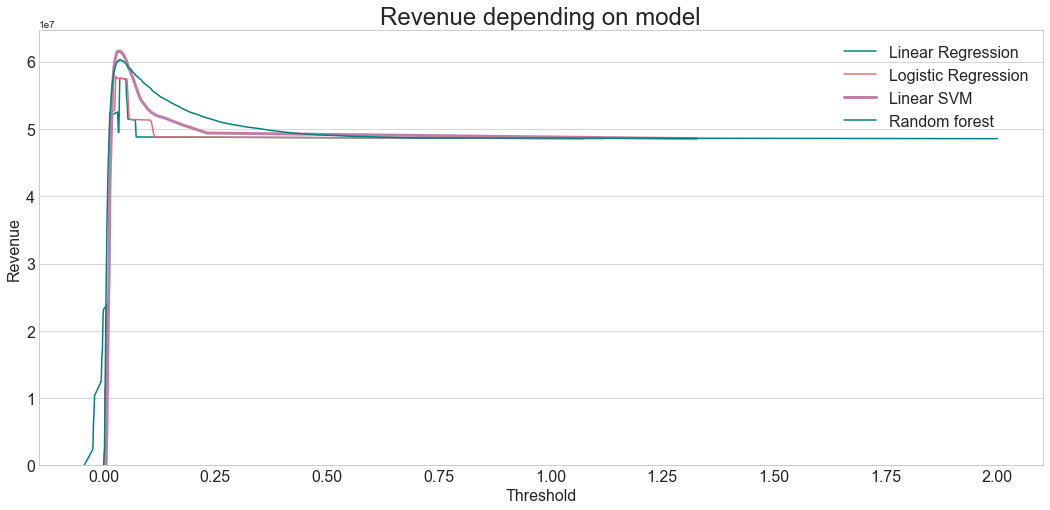

In [59]:
revenue_lineplot(rev_lm,
                 rev_log,
                 rev_rf, 
                 rev_gb)

In [60]:
cutoff_crb = rev_crb.Threshold[rev_crb.Revenue.idxmax()]
cutoff_lm = rev_lm.Threshold[rev_lm.Revenue.idxmax()]
cutoff_log = rev_log.Threshold[rev_log.Revenue.idxmax()]
cutoff_rf = rev_rf.Threshold[rev_rf.Revenue.idxmax()]
cutoff_gb = rev_gb.Threshold[rev_gb.Revenue.idxmax()]
cutoff_xgb = rev_xgb.Threshold[rev_xgb.Revenue.idxmax()]
cutoff_svm_l = rev_svm_l.Threshold[rev_svm_l.Revenue.idxmax()]
cutoff_svm_rbf = rev_svm_rbf.Threshold[rev_svm_rbf.Revenue.idxmax()]
cutoff_svm_poly = rev_svm_poly.Threshold[rev_svm_poly.Revenue.idxmax()]

y_predict_crb_label = np.array(-Dataset.X_test.CRBScore > cutoff_crb).astype(int)
y_predict_lm_label = np.array(y_predict_lm > cutoff_lm).astype(int)
y_predict_log_label = np.array(y_predict_log > cutoff_log).astype(int)
y_predict_rf_label = np.array(y_predict_rf > cutoff_rf).astype(int)
y_predict_gb_label = np.array(y_predict_gb > cutoff_gb).astype(int)
y_predict_xgb_label = np.array(y_predict_xgb > cutoff_xgb).astype(int)
y_predict_svm_l_label = np.array(y_predict_svm_linear > cutoff_svm_l).astype(int)
y_predict_svm_rbf_label = np.array(y_predict_svm_rbf > cutoff_svm_rbf).astype(int)
y_predict_svm_poly_label = np.array(y_predict_svm_poly > cutoff_svm_poly).astype(int)

metrics_crb = metrics.classification_report(y_true = Dataset.y_test, y_pred = y_predict_crb_label, output_dict = True)
metrics_lm = metrics.classification_report(y_true = Dataset.y_test, y_pred = y_predict_lm_label, output_dict = True)
metrics_log = metrics.classification_report(y_true = Dataset.y_test, y_pred = y_predict_log_label, output_dict = True) 
metrics_rf = metrics.classification_report(y_true = Dataset.y_test, y_pred = y_predict_rf_label, output_dict = True)
metrics_gb = metrics.classification_report(y_true = Dataset.y_test, y_pred = y_predict_gb_label, output_dict = True)
metrics_xgb = metrics.classification_report(y_true = Dataset.y_test, y_pred = y_predict_xgb_label, output_dict = True) 
metrics_svm_l = metrics.classification_report(y_true = Dataset.y_test, y_pred = y_predict_svm_l_label, output_dict = True) 
metrics_svm_rbf = metrics.classification_report(y_true = Dataset.y_test, y_pred = y_predict_svm_rbf_label, output_dict = True) 
metrics_svm_poly = metrics.classification_report(y_true = Dataset.y_test, y_pred = y_predict_svm_poly_label, output_dict = True) 

metrics_df_crb = pd.DataFrame(metrics_crb).T
metrics_df_lm = pd.DataFrame(metrics_lm).T
metrics_df_log = pd.DataFrame(metrics_log).T
metrics_df_rf = pd.DataFrame(metrics_rf).T
metrics_df_gb = pd.DataFrame(metrics_gb).T
metrics_df_xgb = pd.DataFrame(metrics_xgb).T
metrics_df_svm_l = pd.DataFrame(metrics_svm_l).T
metrics_df_svm_rbf = pd.DataFrame(metrics_svm_rbf).T
metrics_df_svm_poly = pd.DataFrame(metrics_svm_poly).T

tmp = pd.concat([metrics_df_crb.loc[['accuracy'],['f1-score']],
                 metrics_df_lm.loc[['accuracy'],['f1-score']],
                 metrics_df_log.loc[['accuracy'],['f1-score']],
                 metrics_df_rf.loc[['accuracy'],['f1-score']],
                 metrics_df_gb.loc[['accuracy'],['f1-score']],
                 metrics_df_xgb.loc[['accuracy'],['f1-score']],
                 metrics_df_svm_l.loc[['accuracy'],['f1-score']],
                 metrics_df_svm_rbf.loc[['accuracy'],['f1-score']],
                 metrics_df_svm_poly.loc[['accuracy'],['f1-score']]
                ])
tmp['model'] = ['CRB',
                'Linear Regression',
                'Logistic Regression',
                'Random Forest',
                'Gradient Boosting Classifier',
                'Xgboost',
                'Linear SVM',
                'RBF SVM',
                'Polynomial SVM']
tmp = tmp[['model', 'f1-score']]
tmp.columns = ['model', 'accuracy']
tmp.index = np.arange(9)
accuracy_df = tmp

tmp = pd.concat([metrics_df_crb.loc[['0', '1'], ['precision', 'recall', 'f1-score']],
                 metrics_df_lm.loc[['0', '1'], ['precision', 'recall', 'f1-score']],
                 metrics_df_log.loc[['0', '1'], ['precision', 'recall', 'f1-score']],
                 metrics_df_rf.loc[['0', '1'], ['precision', 'recall', 'f1-score']],
                 metrics_df_gb.loc[['0', '1'], ['precision', 'recall', 'f1-score']],
                 metrics_df_xgb.loc[['0', '1'], ['precision', 'recall', 'f1-score']],
                 metrics_df_svm_l.loc[['0', '1'], ['precision', 'recall', 'f1-score']],
                 metrics_df_svm_rbf.loc[['0', '1'], ['precision', 'recall', 'f1-score']],
                 metrics_df_svm_poly.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
          ])
tmp['model'] = ['CRB', 'CRB',
                'Linear Regression', 'Linear Regression',
                'Logistic Regression', 'Logistic Regression',
                'Random forest', 'Random forest',
                'Gradient Boosting', 'Gradient Boosting',
                'Xgboost', 'Xgboost',
                'Linear SVM', 'Linear SVM',
                'RBF SVM', 'RBF SVM',
                'Polynomial SVM','Polynomial SVM']
tmp['default'] = tmp.index
tmp = tmp[['model', 'default', 'precision', 'recall', 'f1-score']]
tmp.index = np.arange(18)
f1_df = tmp

**Model accuracy table**
{{accuracy_df}}

Model accuracy is not a very usefull metric for imbalanced dataset, because in credits False Negative is more expensive than False Positeve when it comes to using model to make business decisions.

**Precision, Recall and F1-score table**
{{f1_df}}

Baseline CRB Score has the worst precision among built models, only 4.9% of predicted defaults are actually defaulted loans and it correctly identifies only 13.3% of actual defaults as shown by recall measure.  
On another hand the best performance in terms of precision is shown by Xgboost model (10.2%), but given business nature of credit loans recall plays a more important role and best recall is shown by Random forest model, which correctly identifies 59% of actual defaulted loans.

# Recommendation 

During the model evaluation phase it became apparent that, while linear and logistic regression models offer a noticeable lift in revenue when compared with baseline CRB Score, they fall well behind more sophisticated decision tree based models, in particular, Gradient Booster Classifier.   
  
If a bank is operating in an environment, where regulatory framework requires a high degree of explainability of its credit policy, then my recommendation would be to use Logistic regression, but dedicate additional work for feature engineering. One additional option would be to use decision tree classifiers to generate additional features, later used by logistic regression.    

If the regulatory framework, however, doesn’t require clear explainability of credit policy, then more sophisticated ensemble methods are preferable, because they give a clear predictive power advantage, which translates to increase revenues. 

# Conclusion

Credit scoring is a crucially important measure in the banking sector. A credit rating not only determines whether or not a borrower will be approved for a loan but also determines the interest rate at which the loan will need to be repaid. Building a precise Credit Score allows banks to offer loans to a wider population of customers, with a better price proposition.  
My credit scoring model shows better result, than existing Credit rating bureau score and works relatively fast but it does not mean that it should be immediately put in production.   

Firstly features should be clarified. Financial measures have a huge weight of my model. I want to find out what this measure shows before including them in my model, the same situation with SOR.  Model interpretation is a crucially important step in model validation.  
    
The second thing I want to check is data validity. For example, if the dataset has 670 customers with loans who is 117 years old in one year period, which is unbelievable. Or 'Number of months since first account for the customer’ shows all customers, have accounts younger than 12 years, however, 'Equity' bank was established in 1984. It means that the data source should be evaluated and perhaps customers were sampled non-uniformly for this dataset.  
    
In addition credit score could benefit from additional information about customer: ocupation, years with current employer, address, family status and other. A more comprehensive credit history and performance could increase models predictive power, we could include previous and existing loans count, amount, defaults and repayment information. 

# Reference

1. https://en.wikipedia.org/wiki/General_linear_model 'Comparison to multiple linear regression'
2. https://scikit-learn.org '3.2.4.3.1. sklearn.ensemble.RandomForestClassifier'
3. https://scikit-learn.org '3.2.4.3.5. sklearn.ensemble.GradientBoostingClassifier'
4. https://en.wikipedia.org/wiki/Support-vector_machine 'Support-vector machine'